# Radio Link Failure Prediction Challenge

In [1]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=d10577d8f8fb7cf36648b95f7bc3030d01caffa487d47c8f7a74af02bfea06fb
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [2]:
!pip install XGBoost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.7/139.7 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.0/379.0 KB 16.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers



import pandas as pd
from zipfile import ZipFile
import wget
import py7zr

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

from keras.wrappers.scikit_learn import KerasClassifier

from xgboost import XGBClassifier, plot_importance

from matplotlib import pyplot as plt


Based on template available here: https://github.com/Turkcell/ITU-AIMLin5GChallenge-2021/blob/4938c53979d650f94d5208ff4cb977ea954b6907/RLF_Prediction_ITU_AIML_Challenge_Data/TurkcellExampleProject.ipynb

## Processing the Data

In [5]:
filename = wget.download('https://github.com/Turkcell/ITU-AIMLin5GChallenge-2021/raw/main/RLF_Prediction_ITU_AIML_Challenge_Data/RLF_Prediction_ITU_AIML_Challenge_Data.7z')

In [6]:
archive = py7zr.SevenZipFile('RLF_Prediction_ITU_AIML_Challenge_Data.7z', mode='r')
archive.extractall()
archive.close()

In [7]:
#Read the Data
data_zip_path = "RLF_Prediction_ITU_AIML_Challenge_Data/RegionA.zip"
# Zip file reading
def read_table_from_zip(zip_path, table_name):
    with ZipFile(zip_path) as zip_file:
        with zip_file.open(table_name) as file:
            df = pd.read_csv(file, sep="\t", index_col=0)
            if "datetime" in df:
                df["datetime"] = pd.to_datetime(df["datetime"])
            return df

In [8]:
#Read rl-kpis
rl_kpis = read_table_from_zip(data_zip_path, "rl-kpis.tsv")
print(f"rl_kpis.shape: {rl_kpis.shape}")
rl_kpis.head()

rl_kpis.shape: (1992986, 18)


type   datetime  tip  mlid mw_connection_no   site_id  card_type  \
0  ENK 2018-12-31  FAR  A0BE        1,349,988  RL_;ABDV  cardtype1   
1  ENK 2018-12-31  FAR  A0BI        1,349,988  RL_;ABDV  cardtype1   
2  ENK 2018-12-31  FAR  A5AB        1,344,018  RL_;ABDV  cardtype4   
3  NEC 2018-12-31  FAR  A8CQ        1,351,204  RL_;ABDV  cardtype5   
4  NEC 2018-12-31  FAR  A8DQ        1,351,204  RL_;ABDV  cardtype5   

  adaptive_modulation freq_band  severaly_error_second  error_second  \
0              Enable        f3                    0.0           0.0   
1              Enable        f3                    0.0           0.0   
2              Enable        f3                    0.0           0.0   
3              Enable        f2                    0.0           0.0   
4              Enable        f2                    0.0           0.0   

   unavail_second  avail_time  bbe  rxlevmax  capacity modulation    rlf  
0             0.0        86.4  0.0     -31.0     456.0    1024QAM  False  
1             0.0        86.4  0.0     -30.7     456.0    1024QAM  False  
2             0.0        86.4  0.0     -34.4     406.0     512QAM  False  
3             0.0        86.4  0.0     -35.3     247.0   2048QAM*  False  
4             0.0        86.4  0.0     -35.3     247.0   2048QAM*  False

In [9]:
#Read rl-sites
rl_sites = read_table_from_zip(data_zip_path, "rl-sites.tsv")
print(f"rl-sites.shape: {rl_sites.shape}")
rl_sites.head()

rl-sites.shape: (1674, 3)


site_id  groundheight clutter_class
0  RL_;ABDV      107.9658     OPEN LAND
1  RL_;ABL>       97.9733     OPEN LAND
2  RL_;ABTP        3.0446     OPEN LAND
3  RL_;AC?E       85.0143     OPEN LAND
4  RL_;ADKP      192.9800    DENSE TREE

In [10]:
#Read distances
distances = read_table_from_zip(data_zip_path, "distances.tsv")
print(f"distances.shape: {distances.shape}")
distances.head()

distances.shape: (1694, 1694)


WS_19111  WS_17047  WS_18397  WS_17062  WS_17813  WS_17064  \
WS_19111   0.00000  18.65248  60.37075  41.38519  44.21637  53.29280   
WS_17047  18.65248   0.00000  73.44414  57.53957  60.28748  69.69699   
WS_18397  60.37075  73.44414   0.00000  23.48214  21.31712  19.65172   
WS_17062  41.38519  57.53957  23.48214   0.00000   2.83118  12.15742   
WS_17813  44.21637  60.28748  21.31712   2.83118   0.00000   9.49278   

          WS_19112  WS_17063  WS_18736  WS_17065  ...  RL_]=UC>  RL_]ITCK  \
WS_19111  57.28976  63.45174  62.78558  54.45858  ...  56.29052  39.88633   
WS_17047  73.02779  79.27304  76.94148  69.61372  ...  72.02855  55.54109   
WS_18397  15.23841  16.82054   6.57833  11.65780  ...  15.07187  22.73271   
WS_17062  15.90457  22.06655  23.23233  13.98936  ...  14.98860   3.49734   
WS_17813  13.07339  19.23537  20.65096  11.24145  ...  12.15742   5.24601   

          RL_[KBDF  RL_X;O@O  RL_b?LMI  RL_]IC?O  RL_S:PQD  RL_JEZWL  \
WS_19111  46.79774  59.53805  42.80078  41.30192  41.46846  47.79698   
WS_17047  63.03539  76.02551  58.87189  56.87341  57.53957  63.78482   
WS_18397  20.48442  20.40115  21.98328  21.65020  22.81598  18.98556   
WS_17062   5.49582  18.40267   1.66540   2.99772   0.91597   6.41179   
WS_17813   2.74791  15.73803   1.41559   3.99696   2.74791   3.58061   

          RL_LKEII  RL_[EOMJ  
WS_19111  52.29356  42.63424  
WS_17047  67.44870  58.62208  
WS_18397  12.82358  21.98328  
WS_17062  11.90761   1.49886  
WS_17813   9.24297   1.66540  

[5 rows x 1694 columns]

In [11]:
#Read met-forecast
met_forecast = read_table_from_zip(data_zip_path, "met-forecast.tsv")
print(f"met-forecast.shape: {met_forecast.shape}")
met_forecast.head()

met-forecast.shape: (20323, 38)


station_no   datetime report_time weather_day1  temp_max_day1  \
0   WS_17047 2018-01-02     evening   heavy rain             10   
1   WS_17047 2018-01-02     morning   heavy rain             10   
2   WS_17062 2018-01-02     evening   heavy rain             12   
3   WS_17062 2018-01-02     morning   heavy rain             12   
4   WS_17063 2018-01-02     evening   heavy rain             13   

   temp_min_day1  humidity_max_day1  humidity_min_day1  wind_dir_day1  \
0              6               96.0               82.0            6.0   
1              6               96.0               82.0            6.0   
2              9               96.0               80.0           84.0   
3              9               96.0               80.0           84.0   
4              9               95.0               78.0           87.0   

   wind_speed_day1  ... humidity_min_day4  wind_dir_day4  wind_speed_day4  \
0             19.0  ...              57.0          185.0             12.0   
1             19.0  ...              57.0          185.0             12.0   
2             10.0  ...              57.0          114.0             10.0   
3             10.0  ...              57.0          114.0             10.0   
4             10.0  ...              57.0          134.0             11.0   

   weather_day5  temp_max_day5  temp_min_day5  humidity_max_day5  \
0    few clouds             14              8               90.0   
1    few clouds             14              8               90.0   
2    few clouds             17             10               78.0   
3    few clouds             17             10               78.0   
4    few clouds             17             10               78.0   

  humidity_min_day5  wind_dir_day5  wind_speed_day5  
0              70.0          210.0             16.0  
1              70.0          210.0             16.0  
2              67.0          107.0             14.0  
3              67.0          107.0             14.0  
4              63.0          131.0             14.0  

[5 rows x 38 columns]

In [12]:
#Read met-stations
met_stations = read_table_from_zip(data_zip_path, "met-stations.tsv")
print(f"met-stations.shape: {met_stations.shape}")
met_stations.head()

met-stations.shape: (20, 3)


station_no  height     clutter_class
0   WS_17047     381        DENSE TREE
1   WS_17062       5  LOW-MEDIUM URBAN
2   WS_17063      99           AIRPORT
3   WS_17064      18     OPEN IN URBAN
4   WS_17065     123  LOW-SPARSE URBAN

In [13]:
#Preapre Labels
# Firstly, only get unique entry identifiers and RLF column.
# For rl-kpis, unique entry identifiers are 'datetime', 'site_id' and 'mlid'.
df_labels = rl_kpis[["datetime", "site_id", "mlid"]]
df_labels.head()

datetime   site_id  mlid
0 2018-12-31  RL_;ABDV  A0BE
1 2018-12-31  RL_;ABDV  A0BI
2 2018-12-31  RL_;ABDV  A5AB
3 2018-12-31  RL_;ABDV  A8CQ
4 2018-12-31  RL_;ABDV  A8DQ

In [14]:
#Prepare target days (prediction days)

#  Prepare columns for the following days. We will join data with these columns to find RLF
prediction_interval = 7

for i in range(prediction_interval):
  df_labels[f"T+{i+1}"] = df_labels["datetime"] + pd.DateOffset(days=i+1)
df_labels.head()

<ipython-input-14-ecdce09fb915>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels[f"T+{i+1}"] = df_labels["datetime"] + pd.DateOffset(days=i+1)


datetime   site_id  mlid        T+1        T+2        T+3        T+4  \
0 2018-12-31  RL_;ABDV  A0BE 2019-01-01 2019-01-02 2019-01-03 2019-01-04   
1 2018-12-31  RL_;ABDV  A0BI 2019-01-01 2019-01-02 2019-01-03 2019-01-04   
2 2018-12-31  RL_;ABDV  A5AB 2019-01-01 2019-01-02 2019-01-03 2019-01-04   
3 2018-12-31  RL_;ABDV  A8CQ 2019-01-01 2019-01-02 2019-01-03 2019-01-04   
4 2018-12-31  RL_;ABDV  A8DQ 2019-01-01 2019-01-02 2019-01-03 2019-01-04   

         T+5        T+6        T+7  
0 2019-01-05 2019-01-06 2019-01-07  
1 2019-01-05 2019-01-06 2019-01-07  
2 2019-01-05 2019-01-06 2019-01-07  
3 2019-01-05 2019-01-06 2019-01-07  
4 2019-01-05 2019-01-06 2019-01-07

In [15]:
#Join dataset to get RLF colunms for the target days
rl_kpis_view = rl_kpis[["datetime", "site_id", "mlid", "rlf"]]
for i in range(prediction_interval):
  target_day_column_name = f"T+{i+1}"

  df_labels = df_labels.merge(rl_kpis_view, 
                  how = "left", 
                  left_on = ("site_id", "mlid", target_day_column_name),
                  right_on = ("site_id", "mlid", "datetime"),
                  suffixes = ("", "_y")
  )
  df_labels.rename(columns={"rlf": f"{target_day_column_name}_rlf"}, inplace=True)
df_labels.drop(columns=["datetime_y"], inplace=True)
df_labels.head()

datetime   site_id  mlid        T+1        T+2        T+3        T+4  \
0 2018-12-31  RL_;ABDV  A0BE 2019-01-01 2019-01-02 2019-01-03 2019-01-04   
1 2018-12-31  RL_;ABDV  A0BI 2019-01-01 2019-01-02 2019-01-03 2019-01-04   
2 2018-12-31  RL_;ABDV  A5AB 2019-01-01 2019-01-02 2019-01-03 2019-01-04   
3 2018-12-31  RL_;ABDV  A8CQ 2019-01-01 2019-01-02 2019-01-03 2019-01-04   
4 2018-12-31  RL_;ABDV  A8DQ 2019-01-01 2019-01-02 2019-01-03 2019-01-04   

         T+5        T+6        T+7 T+1_rlf T+2_rlf T+3_rlf T+4_rlf T+5_rlf  \
0 2019-01-05 2019-01-06 2019-01-07   False   False   False   False   False   
1 2019-01-05 2019-01-06 2019-01-07   False   False   False   False   False   
2 2019-01-05 2019-01-06 2019-01-07   False   False   False   False   False   
3 2019-01-05 2019-01-06 2019-01-07   False   False   False   False   False   
4 2019-01-05 2019-01-06 2019-01-07   False   False   False   False   False   

  T+6_rlf T+7_rlf  
0   False   False  
1   False   False  
2   False   False  
3   False   False  
4   False   False

In [16]:
#Finalize labels for 1-day and 5-day predictions
#For each link (site_id, mlid), we found the RLF for the 5-days (T+1.. T+5) following the given day (T). Now, we will finalize labelling

# 1 day predict is equal to T+1 rlf
df_labels["1-day-predict"] = df_labels["T+1_rlf"]

# Interval predict (3-day predict) is based on T+1, T+2, T+3
following_days_rlf_columns_day3 = [f"T+{i+1}_rlf" for i in range(3)]

# Interval predict (5-day predict) is based on T+1, T+2, T+3, T+4 and T+5
following_days_rlf_columns_day5 = [f"T+{i+1}_rlf" for i in range(5)]

# Interval predict (7-day predict) is based on T+1, T+2, T+3, T+5, T+6, T+7
following_days_rlf_columns_day7 = [f"T+{i+1}_rlf" for i in range(prediction_interval)]

df_labels["3-day-predict"] = df_labels[following_days_rlf_columns_day3].any(axis=1)
df_labels["5-day-predict"] = df_labels[following_days_rlf_columns_day5].any(axis=1)
df_labels["7-day-predict"] = df_labels[following_days_rlf_columns_day7].any(axis=1)

df_labels = df_labels[["datetime", "site_id", "mlid", "1-day-predict", "3-day-predict", "5-day-predict", "7-day-predict"]]

print(f"df_labels.shape: {df_labels.shape}")
print(f"df_labels 1-day rlf sum: {df_labels['1-day-predict'].sum()}")
print(f"df_labels 3-day rlf sum: {df_labels['3-day-predict'].sum()}")
print(f"df_labels 5-day rlf sum: {df_labels['5-day-predict'].sum()}")
print(f"df_labels 7-day rlf sum: {df_labels['7-day-predict'].sum()}")
df_labels.head()

df_labels.shape: (1992986, 7)
df_labels 1-day rlf sum: 1204
df_labels 3-day rlf sum: 3226
df_labels 5-day rlf sum: 5159
df_labels 7-day rlf sum: 7252


datetime   site_id  mlid 1-day-predict  3-day-predict  5-day-predict  \
0 2018-12-31  RL_;ABDV  A0BE         False          False          False   
1 2018-12-31  RL_;ABDV  A0BI         False          False          False   
2 2018-12-31  RL_;ABDV  A5AB         False          False          False   
3 2018-12-31  RL_;ABDV  A8CQ         False          False          False   
4 2018-12-31  RL_;ABDV  A8DQ         False          False          False   

   7-day-predict  
0          False  
1          False  
2          False  
3          False  
4          False

In [17]:
# Join labels with rl-kpis
rl_kpis_with_labels = rl_kpis.merge(df_labels, 
                                    how="left", 
                                    on=["datetime", "site_id", "mlid"])
rl_kpis_with_labels.head()

type   datetime  tip  mlid mw_connection_no   site_id  card_type  \
0  ENK 2018-12-31  FAR  A0BE        1,349,988  RL_;ABDV  cardtype1   
1  ENK 2018-12-31  FAR  A0BI        1,349,988  RL_;ABDV  cardtype1   
2  ENK 2018-12-31  FAR  A5AB        1,344,018  RL_;ABDV  cardtype4   
3  NEC 2018-12-31  FAR  A8CQ        1,351,204  RL_;ABDV  cardtype5   
4  NEC 2018-12-31  FAR  A8DQ        1,351,204  RL_;ABDV  cardtype5   

  adaptive_modulation freq_band  severaly_error_second  ...  avail_time  bbe  \
0              Enable        f3                    0.0  ...        86.4  0.0   
1              Enable        f3                    0.0  ...        86.4  0.0   
2              Enable        f3                    0.0  ...        86.4  0.0   
3              Enable        f2                    0.0  ...        86.4  0.0   
4              Enable        f2                    0.0  ...        86.4  0.0   

   rxlevmax  capacity  modulation    rlf 1-day-predict  3-day-predict  \
0     -31.0     456.0     1024QAM  False         False          False   
1     -30.7     456.0     1024QAM  False         False          False   
2     -34.4     406.0      512QAM  False         False          False   
3     -35.3     247.0    2048QAM*  False         False          False   
4     -35.3     247.0    2048QAM*  False         False          False   

  5-day-predict  7-day-predict  
0         False          False  
1         False          False  
2         False          False  
3         False          False  
4         False          False  

[5 rows x 22 columns]

In [18]:
# Add rl-sites 
rl_kpis_with_sites = rl_kpis_with_labels.merge(rl_sites, on=["site_id"])
rl_kpis_with_sites.head()

type   datetime  tip  mlid mw_connection_no   site_id  card_type  \
0  ENK 2018-12-31  FAR  A0BE        1,349,988  RL_;ABDV  cardtype1   
1  ENK 2018-12-31  FAR  A0BI        1,349,988  RL_;ABDV  cardtype1   
2  ENK 2018-12-31  FAR  A5AB        1,344,018  RL_;ABDV  cardtype4   
3  NEC 2018-12-31  FAR  A8CQ        1,351,204  RL_;ABDV  cardtype5   
4  NEC 2018-12-31  FAR  A8DQ        1,351,204  RL_;ABDV  cardtype5   

  adaptive_modulation freq_band  severaly_error_second  ...  rxlevmax  \
0              Enable        f3                    0.0  ...     -31.0   
1              Enable        f3                    0.0  ...     -30.7   
2              Enable        f3                    0.0  ...     -34.4   
3              Enable        f2                    0.0  ...     -35.3   
4              Enable        f2                    0.0  ...     -35.3   

   capacity  modulation    rlf  1-day-predict  3-day-predict 5-day-predict  \
0     456.0     1024QAM  False          False          False         False   
1     456.0     1024QAM  False          False          False         False   
2     406.0      512QAM  False          False          False         False   
3     247.0    2048QAM*  False          False          False         False   
4     247.0    2048QAM*  False          False          False         False   

   7-day-predict groundheight  clutter_class  
0          False     107.9658      OPEN LAND  
1          False     107.9658      OPEN LAND  
2          False     107.9658      OPEN LAND  
3          False     107.9658      OPEN LAND  
4          False     107.9658      OPEN LAND  

[5 rows x 24 columns]

In [19]:
#Find closest station

#Step 1: Shaping the dataframe so that each row correspond to a weather station and each column corresponds to a rl
labels_station = met_stations["station_no"].values.tolist()
labels_rl_sites = rl_sites["site_id"].values.tolist()
distances.drop(columns=labels_station, inplace=True)
distances.drop(index=labels_rl_sites, inplace=True)
distances.head()


RL_U7MPL  RL_X;ORF  RL_X;OE?  RL_\K[RM  RL_UBUGK  RL_X;OQA  \
WS_19111  50.96124  63.36847  72.61144  68.53121  51.29432  59.53805   
WS_17047  67.19889  79.02323  87.01715  83.85289  67.36543  75.52589   
WS_18397  18.90229  15.90457  14.98860  16.23765  18.23613  17.07035   
WS_17062   9.65932  21.98328  32.30876  27.31256   9.90913  18.15286   
WS_17813   6.91141  19.15210  29.47758  24.48138   7.07795  15.32168   

          RL_\K[LJ  RL_L=SKK  RL_\K[QH  RL_\K[EJ  ...  RL_]=UC>  RL_]ITCK  \
WS_19111  70.86277  85.26848  65.94984  63.78482  ...  56.29052  39.88633   
WS_17047  86.35099  98.75822  82.10422  80.35555  ...  72.02855  55.54109   
WS_18397  18.73575  25.31408  20.31788  22.64944  ...  15.07187  22.73271   
WS_17062  29.56085  45.79850  24.64792  22.81598  ...  14.98860   3.49734   
WS_17813  26.72967  43.05059  21.81674  20.15134  ...  12.15742   5.24601   

          RL_[KBDF  RL_X;O@O  RL_b?LMI  RL_]IC?O  RL_S:PQD  RL_JEZWL  \
WS_19111  46.79774  59.53805  42.80078  41.30192  41.46846  47.79698   
WS_17047  63.03539  76.02551  58.87189  56.87341  57.53957  63.78482   
WS_18397  20.48442  20.40115  21.98328  21.65020  22.81598  18.98556   
WS_17062   5.49582  18.40267   1.66540   2.99772   0.91597   6.41179   
WS_17813   2.74791  15.73803   1.41559   3.99696   2.74791   3.58061   

          RL_LKEII  RL_[EOMJ  
WS_19111  52.29356  42.63424  
WS_17047  67.44870  58.62208  
WS_18397  12.82358  21.98328  
WS_17062  11.90761   1.49886  
WS_17813   9.24297   1.66540  

[5 rows x 1674 columns]

In [20]:
#Step2: Find clostest station
closest_station = distances.idxmin()
df_closest_station = closest_station.to_frame()
df_closest_station = df_closest_station.reset_index(level=0)
df_closest_station.set_axis(["site_id","station_no"], axis=1, inplace=True)
df_closest_station.head()

site_id station_no
0  RL_U7MPL   WS_17064
1  RL_X;ORF   WS_17063
2  RL_X;OE?   WS_18736
3  RL_\K[RM   WS_17063
4  RL_UBUGK   WS_17064

In [21]:
#Add weather stations information
rl_with_stations = rl_kpis_with_sites.merge(df_closest_station, on=["site_id"])
rl_with_stations.head()

type   datetime  tip  mlid mw_connection_no   site_id  card_type  \
0  ENK 2018-12-31  FAR  A0BE        1,349,988  RL_;ABDV  cardtype1   
1  ENK 2018-12-31  FAR  A0BI        1,349,988  RL_;ABDV  cardtype1   
2  ENK 2018-12-31  FAR  A5AB        1,344,018  RL_;ABDV  cardtype4   
3  NEC 2018-12-31  FAR  A8CQ        1,351,204  RL_;ABDV  cardtype5   
4  NEC 2018-12-31  FAR  A8DQ        1,351,204  RL_;ABDV  cardtype5   

  adaptive_modulation freq_band  severaly_error_second  ...  capacity  \
0              Enable        f3                    0.0  ...     456.0   
1              Enable        f3                    0.0  ...     456.0   
2              Enable        f3                    0.0  ...     406.0   
3              Enable        f2                    0.0  ...     247.0   
4              Enable        f2                    0.0  ...     247.0   

   modulation    rlf  1-day-predict  3-day-predict  5-day-predict  \
0     1024QAM  False          False          False          False   
1     1024QAM  False          False          False          False   
2      512QAM  False          False          False          False   
3    2048QAM*  False          False          False          False   
4    2048QAM*  False          False          False          False   

  7-day-predict  groundheight clutter_class  station_no  
0         False      107.9658     OPEN LAND    WS_18403  
1         False      107.9658     OPEN LAND    WS_18403  
2         False      107.9658     OPEN LAND    WS_18403  
3         False      107.9658     OPEN LAND    WS_18403  
4         False      107.9658     OPEN LAND    WS_18403  

[5 rows x 25 columns]

In [22]:
#Add forecast
rl_final = rl_with_stations.merge(met_forecast.drop(index = [2*i for i in range(10161)]), how='outer', on=["station_no", "datetime"]) # We will consider only evening information

In [23]:
# Remove rows where the site-id is undefined
rl_final = rl_final.dropna(subset = ["site_id"])
print(rl_final.shape)
rl_final.head()

(1992986, 61)


type   datetime  tip  mlid mw_connection_no   site_id  card_type  \
0  ENK 2018-12-31  FAR  A0BE        1,349,988  RL_;ABDV  cardtype1   
1  ENK 2018-12-31  FAR  A0BI        1,349,988  RL_;ABDV  cardtype1   
2  ENK 2018-12-31  FAR  A5AB        1,344,018  RL_;ABDV  cardtype4   
3  NEC 2018-12-31  FAR  A8CQ        1,351,204  RL_;ABDV  cardtype5   
4  NEC 2018-12-31  FAR  A8DQ        1,351,204  RL_;ABDV  cardtype5   

  adaptive_modulation freq_band  severaly_error_second  ...  \
0              Enable        f3                    0.0  ...   
1              Enable        f3                    0.0  ...   
2              Enable        f3                    0.0  ...   
3              Enable        f2                    0.0  ...   
4              Enable        f2                    0.0  ...   

   humidity_min_day4  wind_dir_day4  wind_speed_day4  weather_day5  \
0                NaN            NaN              NaN           NaN   
1                NaN            NaN              NaN           NaN   
2                NaN            NaN              NaN           NaN   
3                NaN            NaN              NaN           NaN   
4                NaN            NaN              NaN           NaN   

   temp_max_day5  temp_min_day5 humidity_max_day5 humidity_min_day5  \
0            NaN            NaN               NaN               NaN   
1            NaN            NaN               NaN               NaN   
2            NaN            NaN               NaN               NaN   
3            NaN            NaN               NaN               NaN   
4            NaN            NaN               NaN               NaN   

  wind_dir_day5 wind_speed_day5  
0           NaN             NaN  
1           NaN             NaN  
2           NaN             NaN  
3           NaN             NaN  
4           NaN             NaN  

[5 rows x 61 columns]

## Model

### Preparing the data

In [24]:
# Features available
list(rl_final.columns)

['type',
 'datetime',
 'tip',
 'mlid',
 'mw_connection_no',
 'site_id',
 'card_type',
 'adaptive_modulation',
 'freq_band',
 'severaly_error_second',
 'error_second',
 'unavail_second',
 'avail_time',
 'bbe',
 'rxlevmax',
 'capacity',
 'modulation',
 'rlf',
 '1-day-predict',
 '3-day-predict',
 '5-day-predict',
 '7-day-predict',
 'groundheight',
 'clutter_class',
 'station_no',
 'report_time',
 'weather_day1',
 'temp_max_day1',
 'temp_min_day1',
 'humidity_max_day1',
 'humidity_min_day1',
 'wind_dir_day1',
 'wind_speed_day1',
 'weather_day2',
 'temp_max_day2',
 'temp_min_day2',
 'humidity_max_day2',
 'humidity_min_day2',
 'wind_dir_day2',
 'wind_speed_day2',
 'weather_day3',
 'temp_max_day3',
 'temp_min_day3',
 'humidity_max_day3',
 'humidity_min_day3',
 'wind_dir_day3',
 'wind_speed_day3',
 'weather_day4',
 'temp_max_day4',
 'temp_min_day4',
 'humidity_max_day4',
 'humidity_min_day4',
 'wind_dir_day4',
 'wind_speed_day4',
 'weather_day5',
 'temp_max_day5',
 'temp_min_day5',
 'humidity_

In [25]:
#Feature Selection


categorical_features = ["card_type", "freq_band", "modulation", 'groundheight',
 'clutter_class','weather_day1','weather_day2','weather_day3','weather_day4','weather_day5', 'adaptive_modulation', ]
numerical_features = ["severaly_error_second", "error_second", "unavail_second", "bbe", "rxlevmax", "capacity", "avail_time", "temp_max_day1", "temp_max_day2",
                     "temp_max_day3", "temp_max_day4", "temp_max_day5",  "temp_min_day1", "temp_min_day2",
                     "temp_min_day3", "temp_min_day4", "temp_min_day5", "humidity_max_day1", "humidity_max_day2",
                     "humidity_max_day3", "humidity_max_day4", "humidity_max_day5",  "humidity_min_day1", "humidity_min_day2",
                     "humidity_min_day3", "humidity_min_day4", "humidity_min_day5", "wind_dir_day1", "wind_dir_day2", "wind_dir_day3", "wind_dir_day4", "wind_dir_day5", "wind_speed_day1", "wind_speed_day2", "wind_speed_day3", "wind_speed_day4", "wind_speed_day5"]

features = categorical_features + numerical_features

In [26]:
# Simple undersampling
np.random.seed(1234)
### attention
cond_rlf = rl_final["7-day-predict"].astype('bool') # otherwise some we have some -1
rlf_count = cond_rlf.sum()
print("rlf count: ", rlf_count)

# Get sample index from non rlf columns with 1:3 ratio
sampled_non_rlf_indicies = np.random.choice(rl_final[~cond_rlf].index, size=rlf_count*2)
rlf_indicies = np.array(rl_final[cond_rlf].index)

sampled_data_indicies = list(sampled_non_rlf_indicies) + list(rlf_indicies)
sampled_data = rl_final.loc[sampled_data_indicies]
sampled_data.shape

rlf count:  7252


(21756, 61)

In [27]:
#Splitting training and testing data (no CV so far)
df_training, df_test = train_test_split(sampled_data, test_size=0.2)
df_train, df_cv = train_test_split(df_training, test_size=0.25)
print(f"df_train.shape: {df_train.shape} | df_test.shape: {df_test.shape} | df_cv.shape: {df_cv.shape}")

df_train.shape: (13053, 61) | df_test.shape: (4352, 61) | df_cv.shape: (4351, 61)


In [28]:
# Convert categorical columns to one hot vector
# Merge them with numerical columns
# Return X data, column names, and encoder for future usage

def preprocessing(df, numerical_columns=[], categorical_columns=[], one_hot_encoder=None):

    # Handle NA
    # For this simple project, we just remove NA entities.
    df = df.dropna()

    if one_hot_encoder is None:
        print("Creating new one hot encoder")
        # For this project, handle one hot encoding here!
        one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
        one_hot_encoder.fit(df[categorical_columns])
    
        print("one_hot_encoder: ", one_hot_encoder)
        print("*" * 50)
        print("Feature names: ", one_hot_encoder.get_feature_names_out())
        print("*" * 50)
        print("Categories: ", one_hot_encoder.categories_)

    arr_numerical = df[numerical_columns]
    arr_categorical = one_hot_encoder.transform(df[categorical_columns])
    feature_names = numerical_columns + list(one_hot_encoder.get_feature_names_out())
    arr_x = np.concatenate((arr_numerical, arr_categorical),axis=1)
    return df.copy(), arr_x, feature_names, one_hot_encoder

# Preprocess data, and get train data
df_train_dropped, train_x, feature_names, one_hot_encoder = preprocessing(df_train, 
                                                                         numerical_columns=numerical_features, 
                                                                         categorical_columns=categorical_features)

Creating new one hot encoder
one_hot_encoder:  OneHotEncoder(handle_unknown='ignore', sparse=False)
**************************************************
Feature names:  ['card_type_cardtype1' 'card_type_cardtype10' 'card_type_cardtype2'
 'card_type_cardtype4' 'card_type_cardtype5' 'card_type_cardtype6'
 'freq_band_f1' 'freq_band_f2' 'freq_band_f3' 'freq_band_f4'
 'freq_band_f5' 'modulation_1024 QAM' 'modulation_1024QAM'
 'modulation_128QAM' 'modulation_16QAM' 'modulation_2048QAM'
 'modulation_2048QAM*' 'modulation_2048QAM_light*'
 'modulation_2048QAM_std*' 'modulation_256QAM' 'modulation_256QAM(Q)'
 'modulation_512QAM' 'modulation_512QAM(QO)' 'modulation_64QAM'
 'groundheight_1.0' 'groundheight_1.0149' 'groundheight_2.0297'
 'groundheight_3.0446' 'groundheight_3.9814' 'groundheight_4.9962'
 'groundheight_6.0111' 'groundheight_7.026' 'groundheight_8.0408'
 'groundheight_8.9776' 'groundheight_9.9925' 'groundheight_11.0074'
 'groundheight_12.0222' 'groundheight_12.959' 'groundheight_13.9739

In [29]:
train_x.shape

(8641, 389)

In [30]:
# Preprocessing cv data
df_cv_dropepd, cv_x, _, _ = preprocessing(df_test, numerical_columns=numerical_features, 
                             categorical_columns=categorical_features, 
                             one_hot_encoder=one_hot_encoder)

cv_y_1_day = df_cv_dropepd["1-day-predict"].astype('int').to_numpy()
cv_y_3_day = df_cv_dropepd["3-day-predict"].astype('int').to_numpy()
cv_y_5_day = df_cv_dropepd["5-day-predict"].astype('int').to_numpy()
cv_y_7_day = df_cv_dropepd["7-day-predict"].astype('int').to_numpy()

# Preprocessing test data
df_test_dropepd, test_x, _, _ = preprocessing(df_test, numerical_columns=numerical_features, 
                             categorical_columns=categorical_features, 
                             one_hot_encoder=one_hot_encoder)

test_y_1_day = df_test_dropepd["1-day-predict"].astype('int').to_numpy()
test_y_3_day = df_test_dropepd["3-day-predict"].astype('int').to_numpy()
test_y_5_day = df_test_dropepd["5-day-predict"].astype('int').to_numpy()
test_y_7_day = df_test_dropepd["7-day-predict"].astype('int').to_numpy()


### XGBoost

In [31]:
# Buidling
clf_1_day = XGBClassifier(eta = 0.1, n_estimators=125, max_depth = 20)
clf_3_day = XGBClassifier(eta = 0.1, n_estimators=125, max_depth = 20)
clf_5_day = XGBClassifier(eta = 0.1, n_estimators=125, max_depth = 20)
clf_7_day = XGBClassifier(eta = 0.1, n_estimators=125, max_depth = 20)

In [32]:
# Training

train_y_1_day = df_train_dropped["1-day-predict"].astype('int').to_numpy()
train_y_3_day = df_train_dropped["3-day-predict"].astype('int').to_numpy()
train_y_5_day = df_train_dropped["5-day-predict"].astype('int').to_numpy()
train_y_7_day = df_train_dropped["7-day-predict"].astype('int').to_numpy()

eval_set_day1 = [(train_x,  train_y_1_day), (test_x,  test_y_1_day)]
eval_set_day3 = [(train_x,  train_y_3_day), (test_x,  test_y_3_day)]
eval_set_day5 = [(train_x,  train_y_5_day), (test_x,  test_y_5_day)]
eval_set_day7 = [(train_x,  train_y_7_day), (test_x,  test_y_7_day)]

In [33]:
clf_1_day.fit(train_x, train_y_1_day, eval_metric=["error", "logloss"], eval_set=eval_set_day1)

[0]	validation_0-error:0.029048	validation_0-logloss:0.608934	validation_1-error:0.043386	validation_1-logloss:0.611058
[1]	validation_0-error:0.027196	validation_0-logloss:0.539709	validation_1-error:0.040917	validation_1-logloss:0.543787
[2]	validation_0-error:0.027427	validation_0-logloss:0.481283	validation_1-error:0.040212	validation_1-logloss:0.487585
[3]	validation_0-error:0.027427	validation_0-logloss:0.431979	validation_1-error:0.043034	validation_1-logloss:0.440412
[4]	validation_0-error:0.026502	validation_0-logloss:0.389464	validation_1-error:0.040917	validation_1-logloss:0.400176
[5]	validation_0-error:0.025807	validation_0-logloss:0.353148	validation_1-error:0.039859	validation_1-logloss:0.365381
[6]	validation_0-error:0.024997	validation_0-logloss:0.320817	validation_1-error:0.038095	validation_1-logloss:0.335308
[7]	validation_0-error:0.024303	validation_0-logloss:0.292624	validation_1-error:0.038095	validation_1-logloss:0.30963
[8]	validation_0-error:0.023145	validatio

XGBClassifier(eta=0.1, max_depth=20, n_estimators=125)

In [34]:
clf_3_day.fit(train_x, train_y_3_day, eval_metric=["error", "logloss"], eval_set=eval_set_day3)

[0]	validation_0-error:0.061683	validation_0-logloss:0.620136	validation_1-error:0.12381	validation_1-logloss:0.628883
[1]	validation_0-error:0.056243	validation_0-logloss:0.560704	validation_1-error:0.116049	validation_1-logloss:0.577054
[2]	validation_0-error:0.055549	validation_0-logloss:0.510489	validation_1-error:0.11746	validation_1-logloss:0.533236
[3]	validation_0-error:0.05173	validation_0-logloss:0.467443	validation_1-error:0.115344	validation_1-logloss:0.496949
[4]	validation_0-error:0.048258	validation_0-logloss:0.428685	validation_1-error:0.110053	validation_1-logloss:0.465985
[5]	validation_0-error:0.044324	validation_0-logloss:0.394431	validation_1-error:0.104762	validation_1-logloss:0.438959
[6]	validation_0-error:0.044092	validation_0-logloss:0.364497	validation_1-error:0.105115	validation_1-logloss:0.416292
[7]	validation_0-error:0.042356	validation_0-logloss:0.337547	validation_1-error:0.104056	validation_1-logloss:0.396044
[8]	validation_0-error:0.03981	validation_0

XGBClassifier(eta=0.1, max_depth=20, n_estimators=125)

In [35]:
clf_5_day.fit(train_x, train_y_5_day, eval_metric=["error", "logloss"], eval_set=eval_set_day5)

[0]	validation_0-error:0.074297	validation_0-logloss:0.625229	validation_1-error:0.177072	validation_1-logloss:0.640212
[1]	validation_0-error:0.059831	validation_0-logloss:0.568773	validation_1-error:0.162257	validation_1-logloss:0.59492
[2]	validation_0-error:0.053466	validation_0-logloss:0.521195	validation_1-error:0.158377	validation_1-logloss:0.558601
[3]	validation_0-error:0.050341	validation_0-logloss:0.478974	validation_1-error:0.15873	validation_1-logloss:0.527309
[4]	validation_0-error:0.044208	validation_0-logloss:0.442052	validation_1-error:0.153792	validation_1-logloss:0.499498
[5]	validation_0-error:0.043051	validation_0-logloss:0.409911	validation_1-error:0.15097	validation_1-logloss:0.476356
[6]	validation_0-error:0.042125	validation_0-logloss:0.381885	validation_1-error:0.150265	validation_1-logloss:0.456788
[7]	validation_0-error:0.037611	validation_0-logloss:0.355571	validation_1-error:0.14709	validation_1-logloss:0.437297
[8]	validation_0-error:0.03495	validation_0-

XGBClassifier(eta=0.1, max_depth=20, n_estimators=125)

In [36]:
clf_7_day.fit(train_x, train_y_7_day, eval_metric=["error", "logloss"], eval_set=eval_set_day7)

[0]	validation_0-error:0.079158	validation_0-logloss:0.627836	validation_1-error:0.186949	validation_1-logloss:0.642948
[1]	validation_0-error:0.064692	validation_0-logloss:0.573655	validation_1-error:0.174603	validation_1-logloss:0.601694
[2]	validation_0-error:0.058442	validation_0-logloss:0.528475	validation_1-error:0.157672	validation_1-logloss:0.567666
[3]	validation_0-error:0.05254	validation_0-logloss:0.488331	validation_1-error:0.149559	validation_1-logloss:0.537073
[4]	validation_0-error:0.05092	validation_0-logloss:0.453067	validation_1-error:0.146032	validation_1-logloss:0.511593
[5]	validation_0-error:0.046522	validation_0-logloss:0.420395	validation_1-error:0.140388	validation_1-logloss:0.488131
[6]	validation_0-error:0.041662	validation_0-logloss:0.39111	validation_1-error:0.14321	validation_1-logloss:0.46819
[7]	validation_0-error:0.040967	validation_0-logloss:0.36604	validation_1-error:0.13933	validation_1-logloss:0.449678
[8]	validation_0-error:0.038074	validation_0-lo

XGBClassifier(eta=0.1, max_depth=20, n_estimators=125)

In [37]:
results = clf_1_day.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

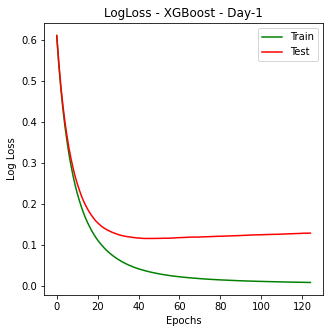

In [38]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["logloss"], 'g', label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], 'r', label="Test")
ax.legend()
plt.ylabel("Log Loss")
plt.xlabel("Epochs")
plt.title("LogLoss - XGBoost - Day-1")
plt.show()


In [39]:
results = clf_3_day.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

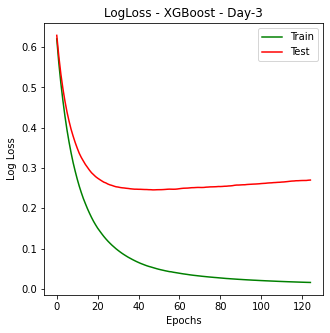

In [40]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["logloss"], 'g', label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], 'r', label="Test")
ax.legend()
plt.ylabel("Log Loss")
plt.xlabel("Epochs")
plt.title("LogLoss - XGBoost - Day-3")
plt.show()

In [41]:
results = clf_5_day.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

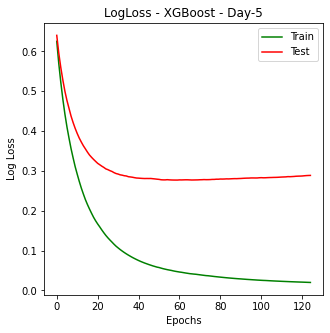

In [42]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["logloss"], 'g', label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], 'r', label="Test")
ax.legend()
plt.ylabel("Log Loss")
plt.xlabel("Epochs")
plt.title("LogLoss - XGBoost - Day-5")
plt.show()

In [43]:
results = clf_7_day.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

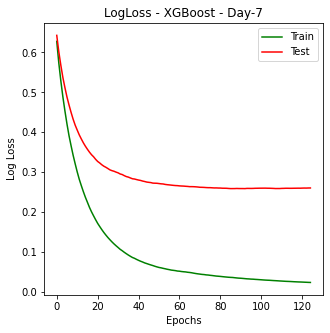

In [44]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["logloss"], 'g', label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], 'r', label="Test")
ax.legend()
plt.ylabel("Log Loss")
plt.xlabel("Epochs")
plt.title("LogLoss - XGBoost - Day-7")
plt.show()

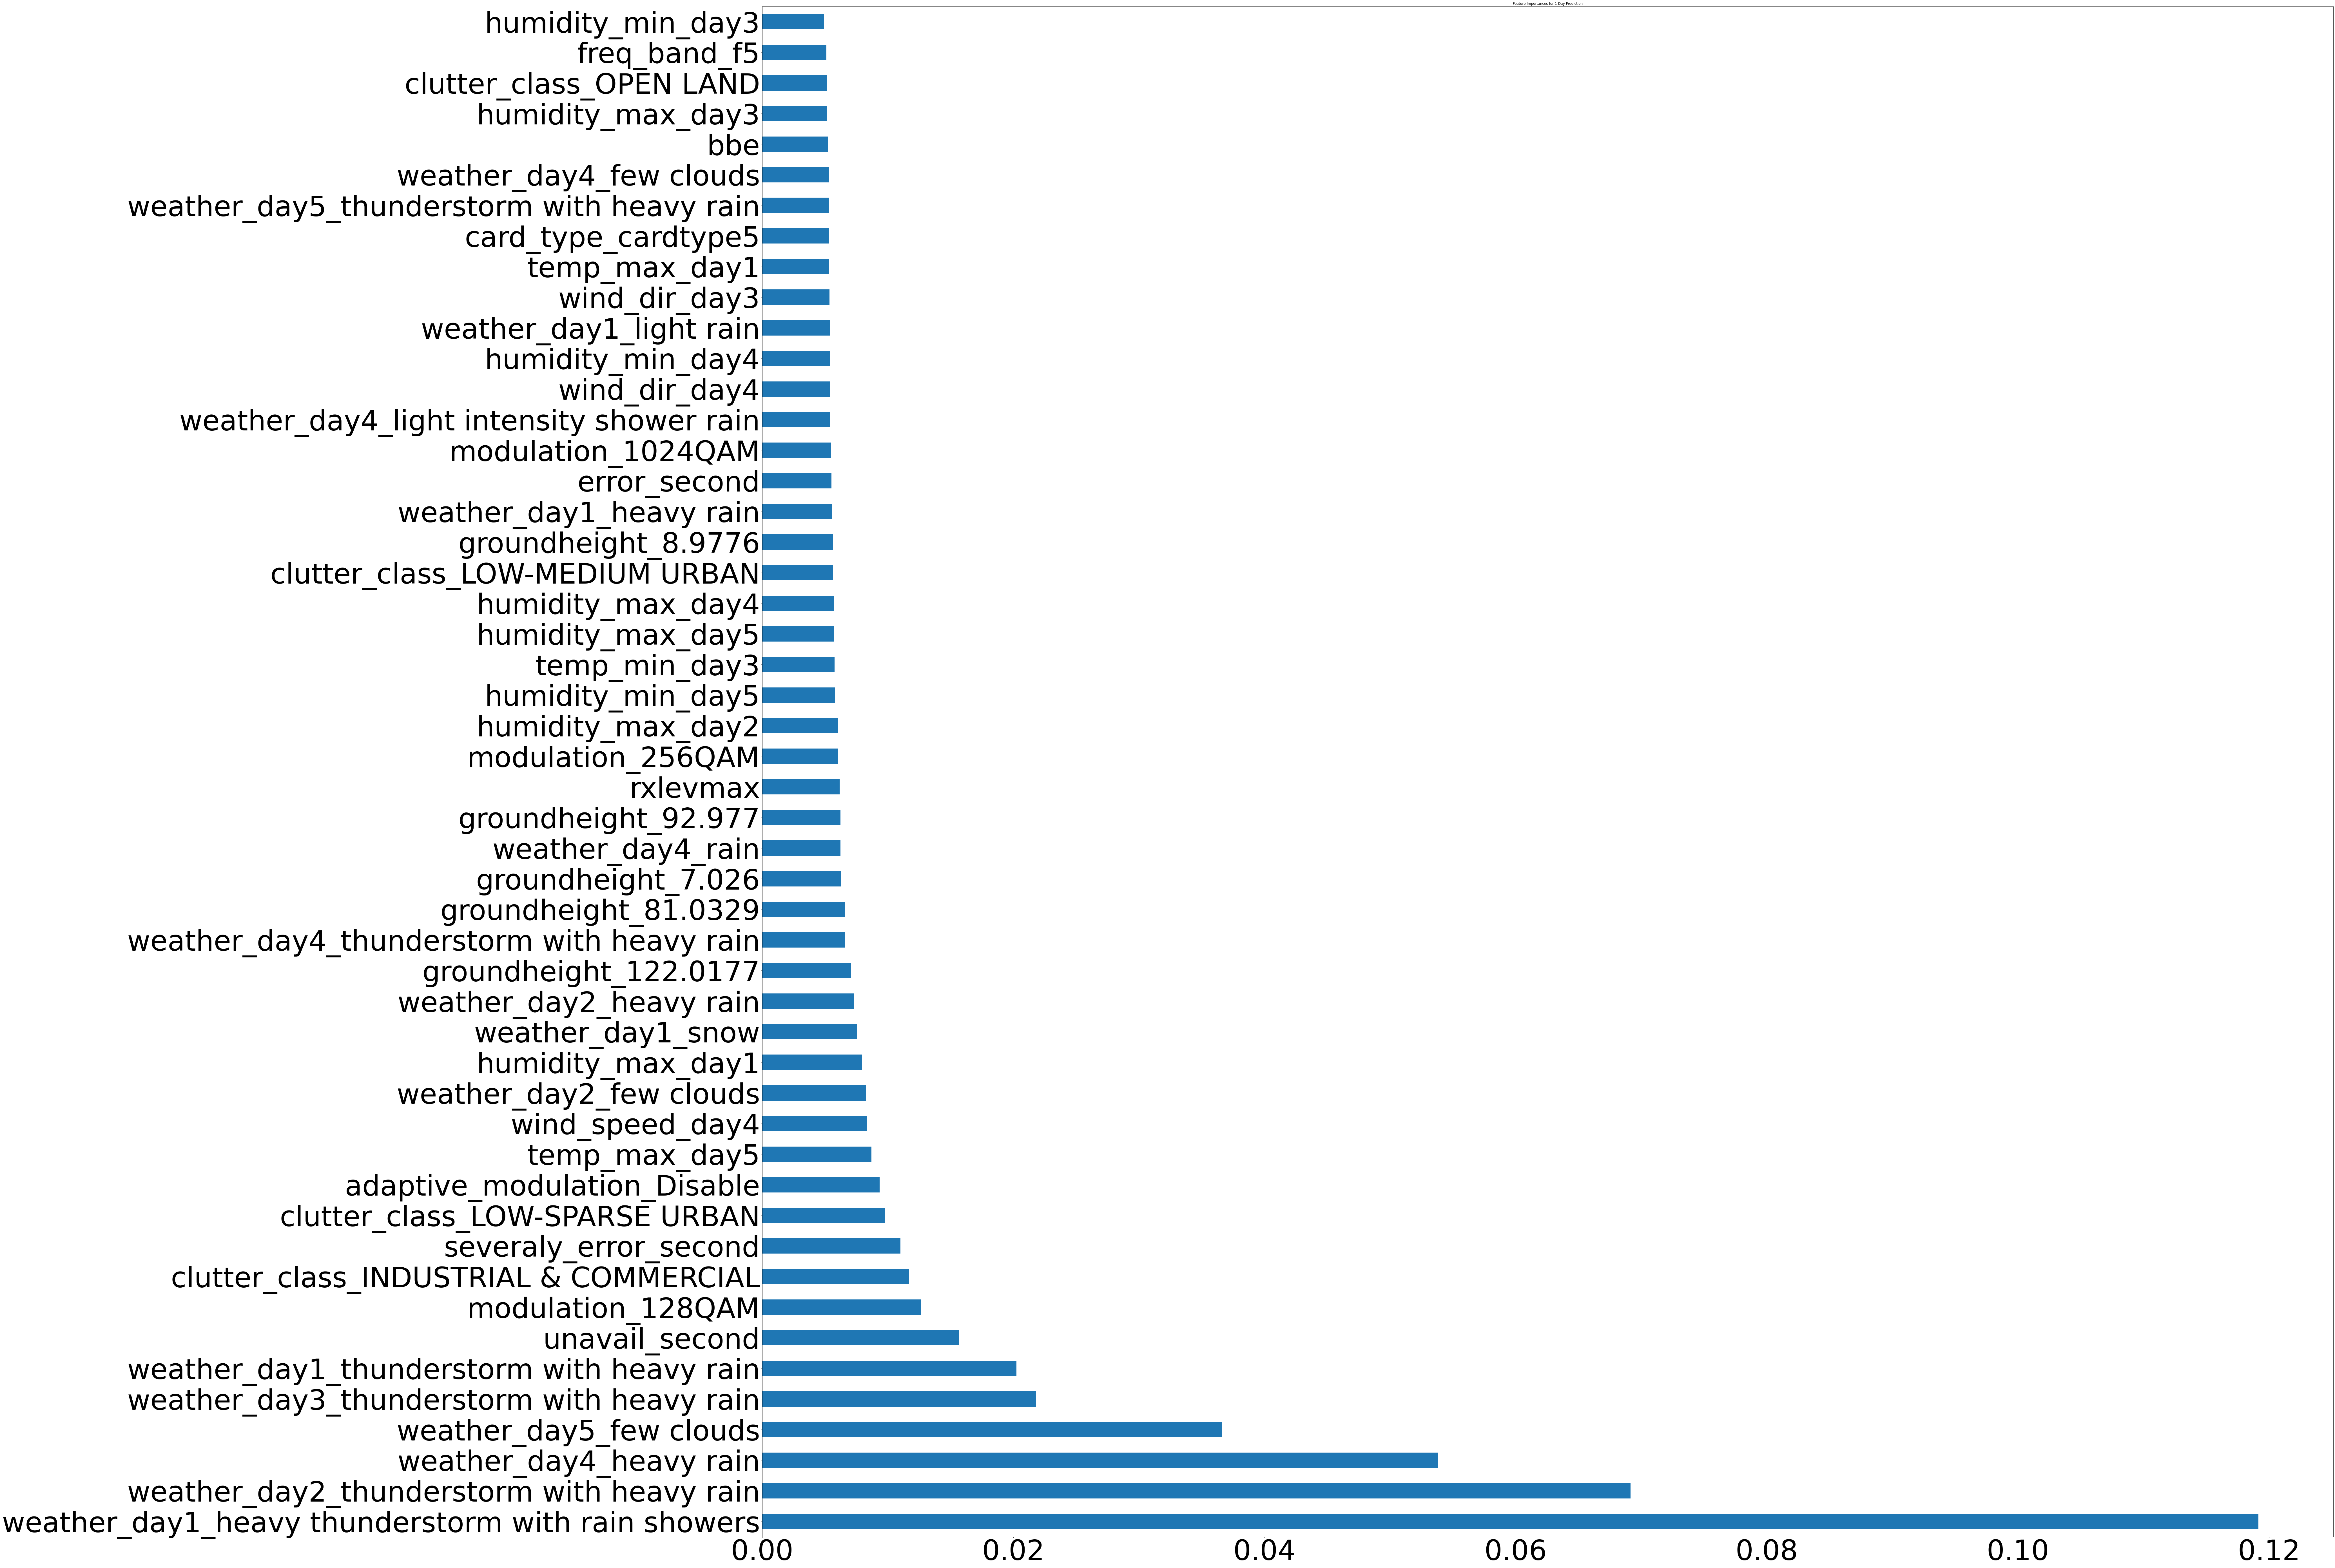

In [45]:
feat_importances = pd.Series(clf_1_day.feature_importances_, index=feature_names)
plt.figure(figsize=(100, 100))
feat_importances.nlargest(50).plot(kind='barh', title = "Feature Importances for 1-Day Prediction", fontsize = 100) # 386 features in total

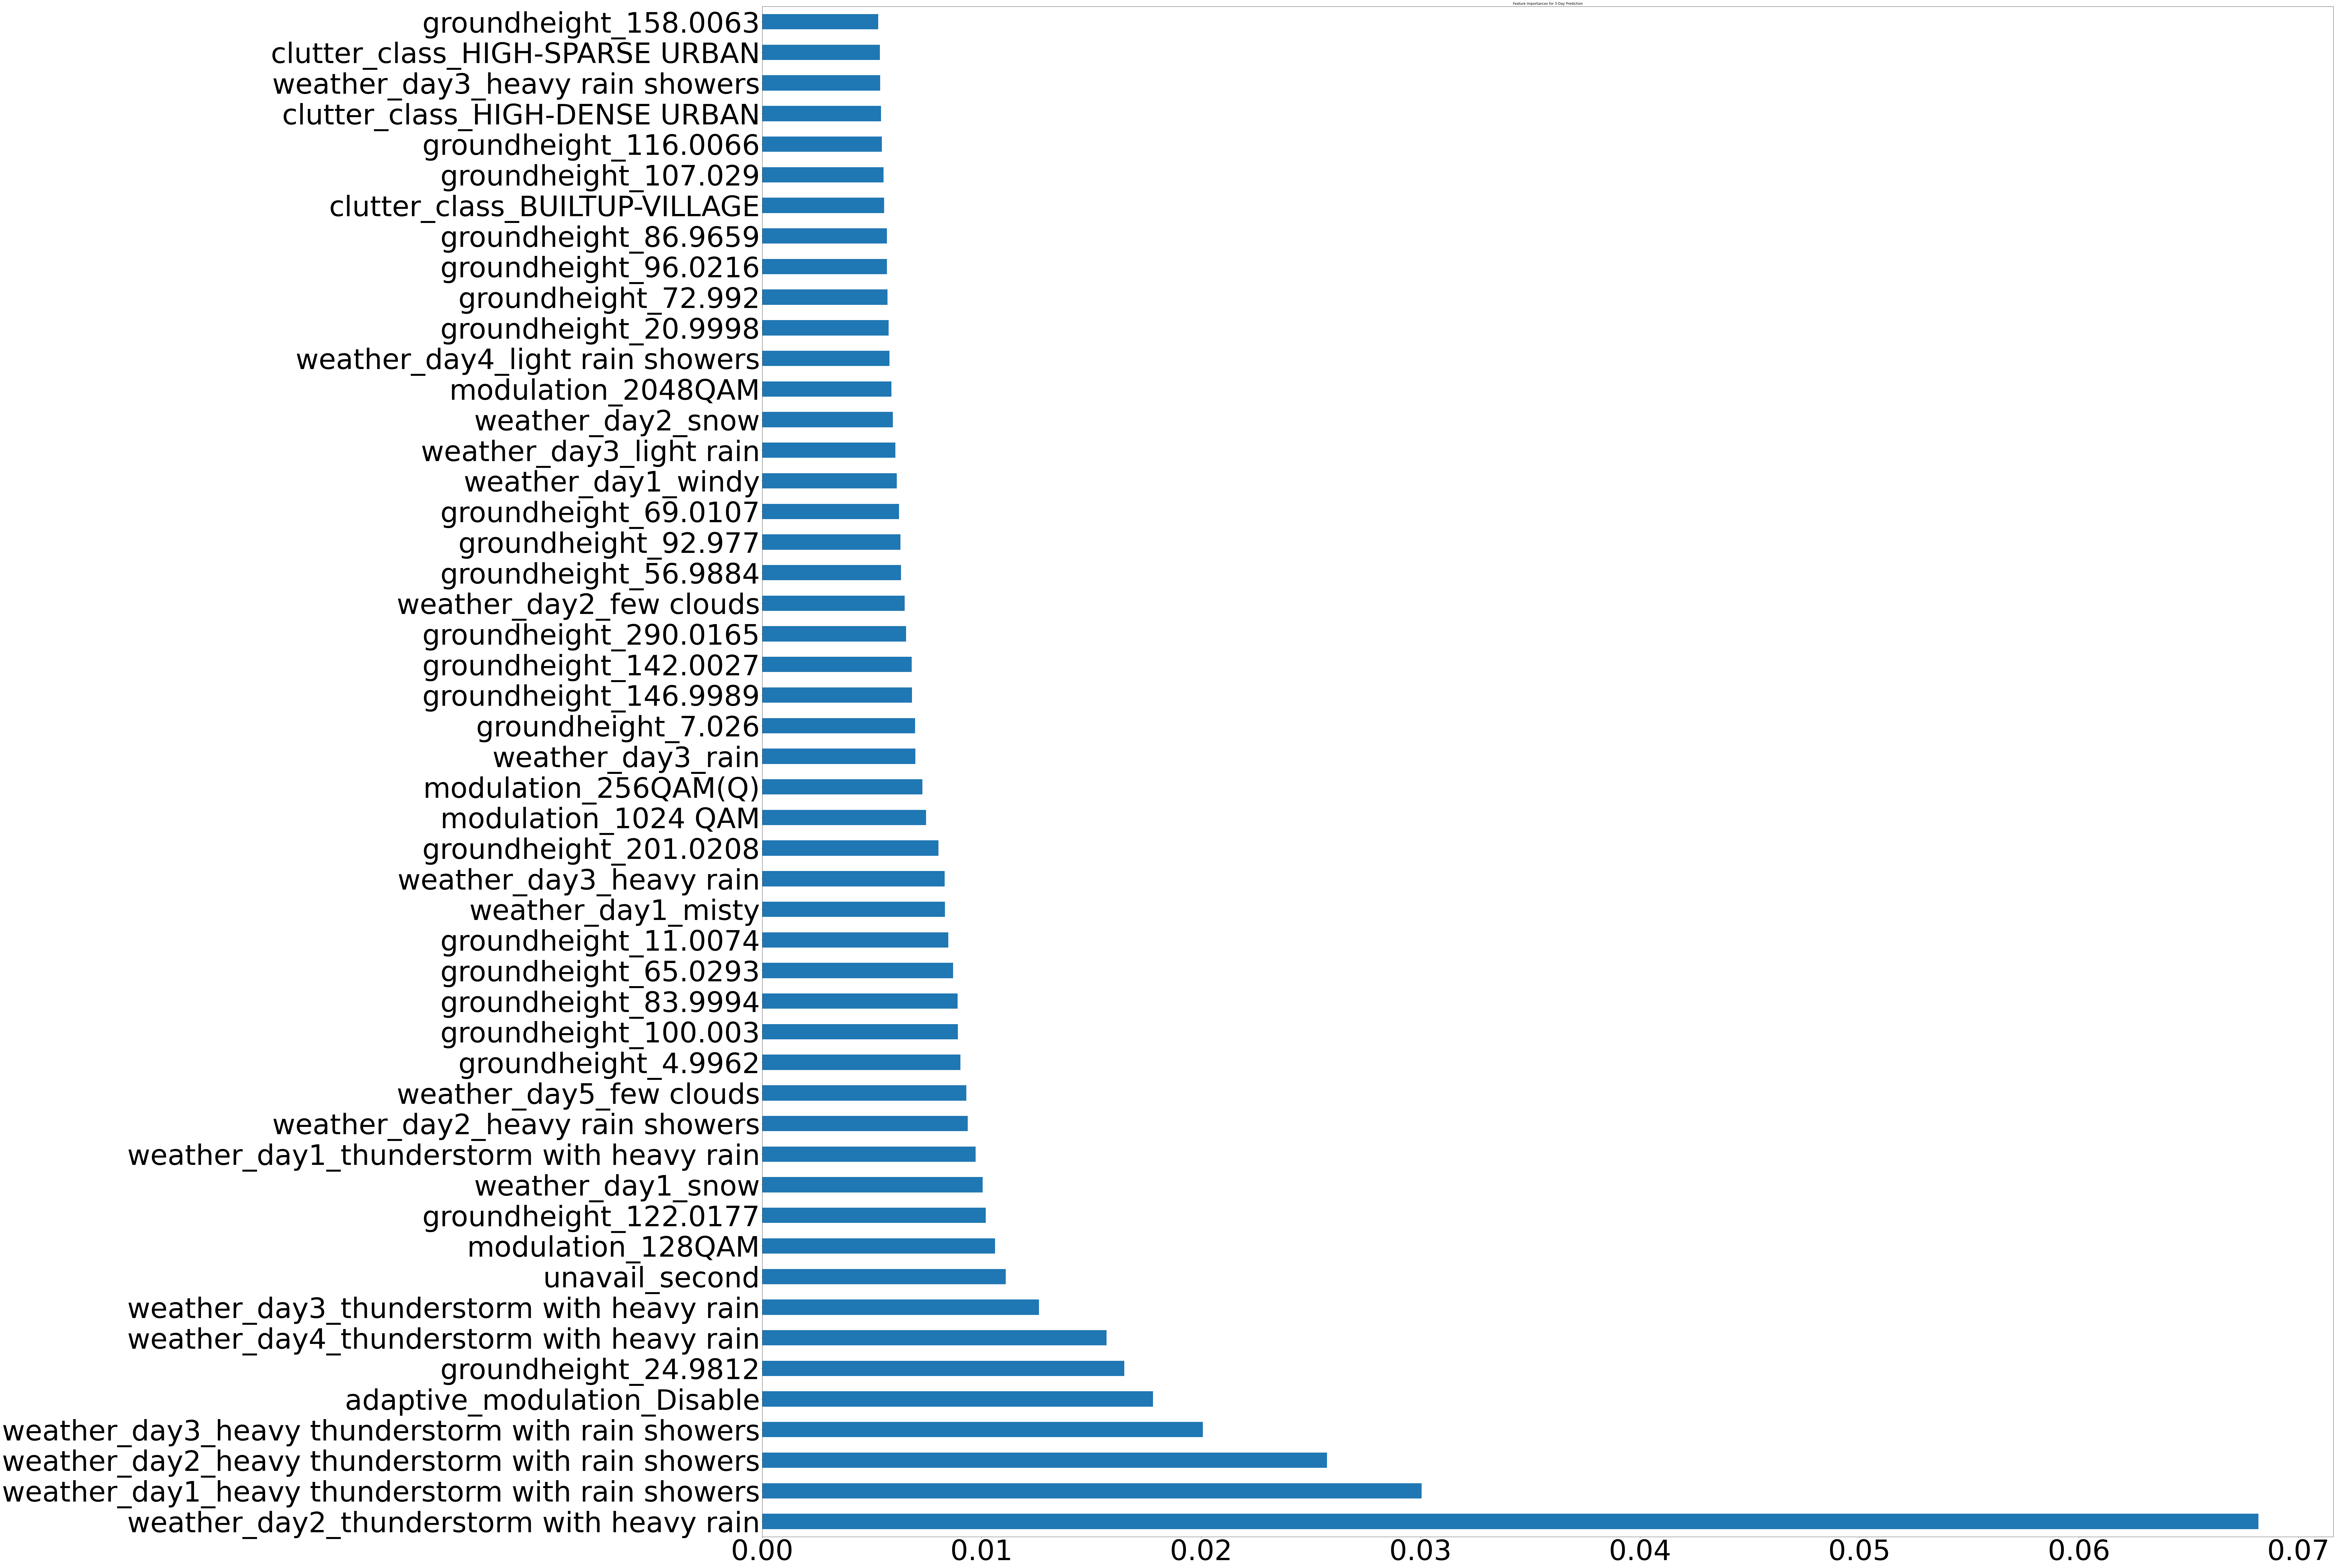

In [46]:
feat_importances = pd.Series(clf_3_day.feature_importances_, index=feature_names)
plt.figure(figsize=(100, 100))
feat_importances.nlargest(50).plot(kind='barh', title = "Feature Importances for 3-Day Prediction", fontsize = 100) #386 features in total

['severaly_error_second', 'error_second', 'unavail_second', 'bbe', 'rxlevmax', 'capacity', 'avail_time', 'temp_max_day1', 'temp_max_day2', 'temp_max_day3', 'temp_max_day4', 'temp_max_day5', 'temp_min_day1', 'temp_min_day2', 'temp_min_day3', 'temp_min_day4', 'temp_min_day5', 'humidity_max_day1', 'humidity_max_day2', 'humidity_max_day3', 'humidity_max_day4', 'humidity_max_day5', 'humidity_min_day1', 'humidity_min_day2', 'humidity_min_day3', 'humidity_min_day4', 'humidity_min_day5', 'wind_dir_day1', 'wind_dir_day2', 'wind_dir_day3', 'wind_dir_day4', 'wind_dir_day5', 'wind_speed_day1', 'wind_speed_day2', 'wind_speed_day3', 'wind_speed_day4', 'wind_speed_day5', 'card_type_cardtype1', 'card_type_cardtype10', 'card_type_cardtype2', 'card_type_cardtype4', 'card_type_cardtype5', 'card_type_cardtype6', 'freq_band_f1', 'freq_band_f2', 'freq_band_f3', 'freq_band_f4', 'freq_band_f5', 'modulation_1024 QAM', 'modulation_1024QAM', 'modulation_128QAM', 'modulation_16QAM', 'modulation_2048QAM', 'modulat

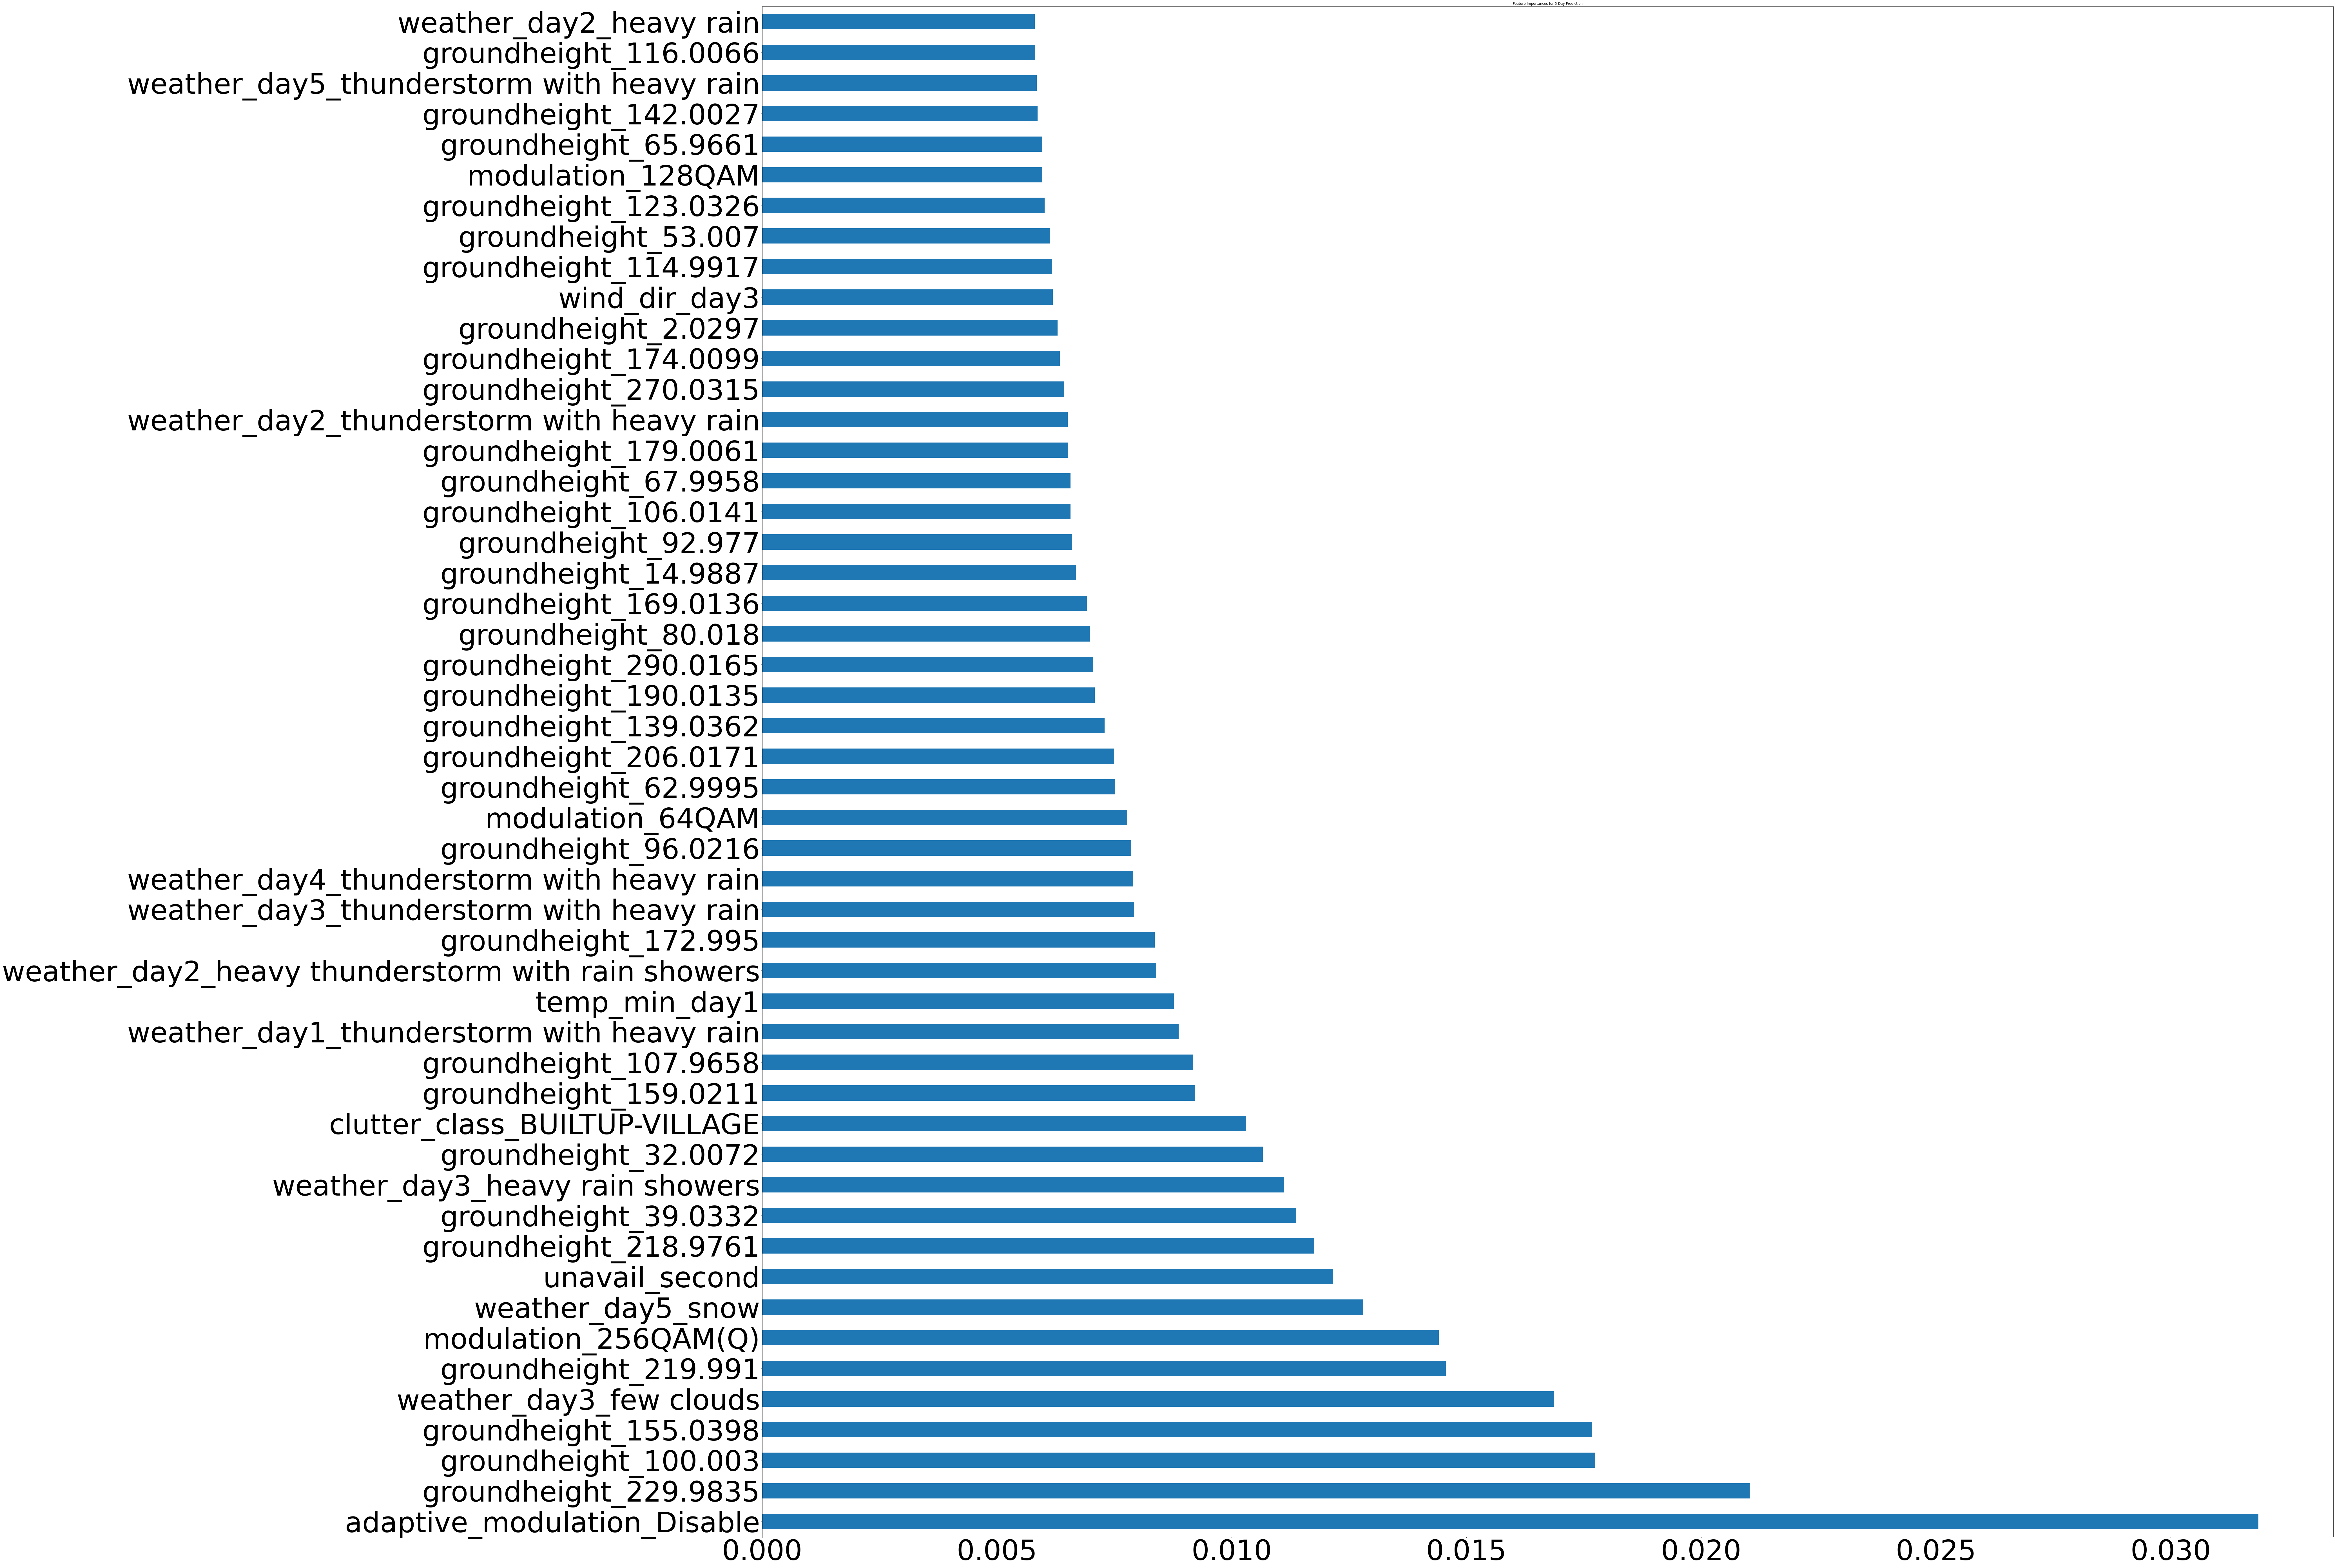

In [47]:
feat_importances = pd.Series(clf_5_day.feature_importances_, index=feature_names)
feat_importances.sort_values(ascending= False)
feat_importances_array = feat_importances.index.values.tolist()
print(feat_importances_array[:80])
plt.figure(figsize=(100, 100))
feat_importances.nlargest(50).plot(kind='barh', title = "Feature Importances for 5-Day Prediction", fontsize = 100) #386 features in total

['severaly_error_second', 'error_second', 'unavail_second', 'bbe', 'rxlevmax', 'capacity', 'avail_time', 'temp_max_day1', 'temp_max_day2', 'temp_max_day3', 'temp_max_day4', 'temp_max_day5', 'temp_min_day1', 'temp_min_day2', 'temp_min_day3', 'temp_min_day4', 'temp_min_day5', 'humidity_max_day1', 'humidity_max_day2', 'humidity_max_day3', 'humidity_max_day4', 'humidity_max_day5', 'humidity_min_day1', 'humidity_min_day2', 'humidity_min_day3', 'humidity_min_day4', 'humidity_min_day5', 'wind_dir_day1', 'wind_dir_day2', 'wind_dir_day3', 'wind_dir_day4', 'wind_dir_day5', 'wind_speed_day1', 'wind_speed_day2', 'wind_speed_day3', 'wind_speed_day4', 'wind_speed_day5', 'card_type_cardtype1', 'card_type_cardtype10', 'card_type_cardtype2', 'card_type_cardtype4', 'card_type_cardtype5', 'card_type_cardtype6', 'freq_band_f1', 'freq_band_f2', 'freq_band_f3', 'freq_band_f4', 'freq_band_f5', 'modulation_1024 QAM', 'modulation_1024QAM', 'modulation_128QAM', 'modulation_16QAM', 'modulation_2048QAM', 'modulat

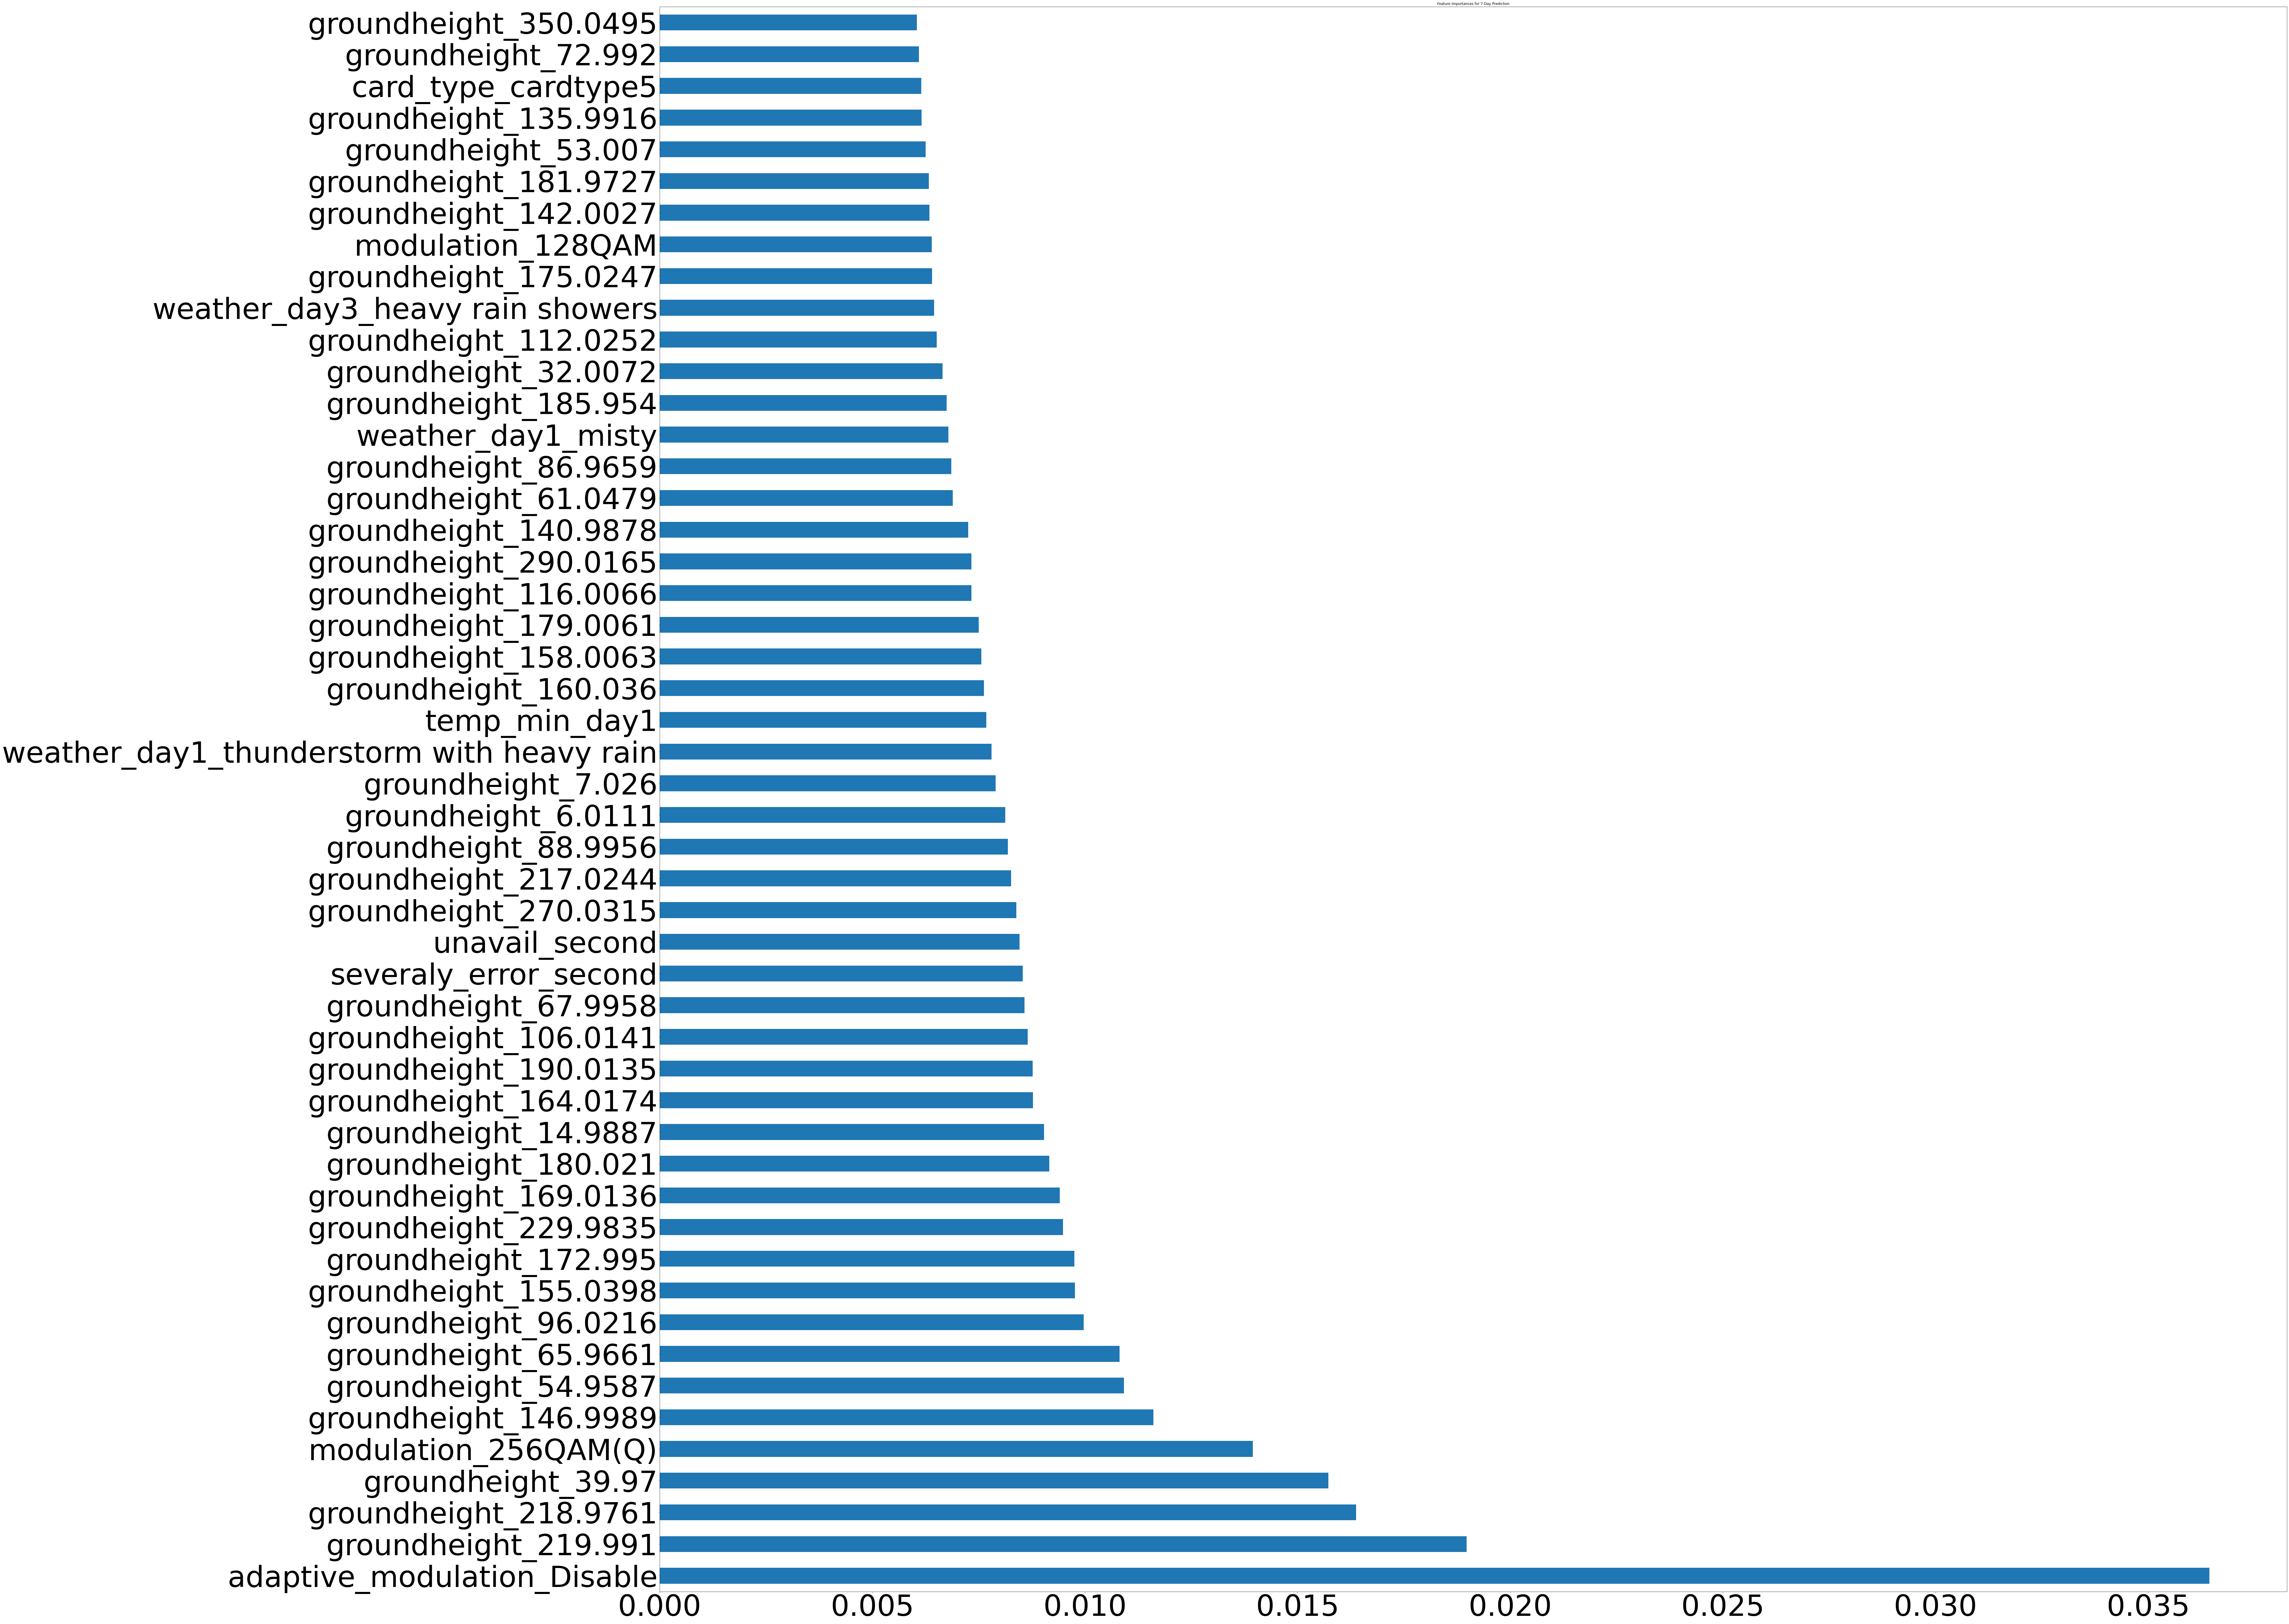

In [48]:
feat_importances = pd.Series(clf_7_day.feature_importances_, index=feature_names)
feat_importances.sort_values(ascending= False)
feat_importances_array = feat_importances.index.values.tolist()
print(feat_importances_array[:80])
plt.figure(figsize=(100, 100))
feat_importances.nlargest(50).plot(kind='barh', title = "Feature Importances for 7-Day Prediction", fontsize = 100) #386 features in total

In [49]:
#Predicting
train_pred_1_day_xgboost = clf_1_day.predict(train_x)
cv_pred_1_day_xgboost = clf_1_day.predict(cv_x)
test_pred_1_day_xgboost = clf_1_day.predict(test_x)

train_pred_3_day_xgboost = clf_3_day.predict(train_x)
cv_pred_3_day_xgboost = clf_3_day.predict(cv_x)
test_pred_3_day_xgboost = clf_3_day.predict(test_x)

train_pred_5_day_xgboost = clf_5_day.predict(train_x)
cv_pred_5_day_xgboost = clf_5_day.predict(cv_x)
test_pred_5_day_xgboost = clf_5_day.predict(test_x)

train_pred_7_day_xgboost = clf_7_day.predict(train_x)
cv_pred_7_day_xgboost = clf_7_day.predict(cv_x)
test_pred_7_day_xgboost = clf_7_day.predict(test_x)

In [50]:
#pred 1 day

print("*********** SCORE for 1-DAY predict (Training Data) ***********")
print(classification_report(train_pred_1_day_xgboost,train_y_1_day))

print()
print("*********** SCORE for 1-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_1_day_xgboost,cv_y_1_day))


*********** SCORE for 1-DAY predict (Training Data) ***********
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8154
           1       1.00      1.00      1.00       487

    accuracy                           1.00      8641
   macro avg       1.00      1.00      1.00      8641
weighted avg       1.00      1.00      1.00      8641


*********** SCORE for 1-DAY predict (CV Data) ***********
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2729
           1       0.57      0.84      0.68       106

    accuracy                           0.97      2835
   macro avg       0.78      0.91      0.83      2835
weighted avg       0.98      0.97      0.97      2835



In [51]:
#pred 3 day

print("*********** SCORE for 3-DAY predict (Training Data) ***********")
print(classification_report(train_pred_3_day_xgboost,train_y_3_day))

print()
print("*********** SCORE for 3-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_3_day_xgboost,cv_y_3_day))


*********** SCORE for 3-DAY predict (Training Data) ***********
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7334
           1       1.00      1.00      1.00      1307

    accuracy                           1.00      8641
   macro avg       1.00      1.00      1.00      8641
weighted avg       1.00      1.00      1.00      8641


*********** SCORE for 3-DAY predict (CV Data) ***********
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2516
           1       0.58      0.82      0.68       319

    accuracy                           0.91      2835
   macro avg       0.78      0.87      0.81      2835
weighted avg       0.93      0.91      0.92      2835



In [52]:
#pred 5 day

print("*********** SCORE for 5-DAY predict (Training Data) ***********")
print(classification_report(train_pred_5_day_xgboost,train_y_5_day))

print()
print("*********** SCORE for 5-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_5_day_xgboost,cv_y_5_day))


*********** SCORE for 5-DAY predict (Training Data) ***********
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6540
           1       1.00      1.00      1.00      2101

    accuracy                           1.00      8641
   macro avg       1.00      1.00      1.00      8641
weighted avg       1.00      1.00      1.00      8641


*********** SCORE for 5-DAY predict (CV Data) ***********
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2246
           1       0.69      0.82      0.75       589

    accuracy                           0.89      2835
   macro avg       0.82      0.86      0.84      2835
weighted avg       0.90      0.89      0.89      2835



In [53]:
#pred 7 day

print("*********** SCORE for 7-DAY predict (Training Data) ***********")
print(classification_report(train_pred_7_day_xgboost,train_y_7_day))

print()
print("*********** SCORE for 7-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_7_day_xgboost,cv_y_7_day))


*********** SCORE for 7-DAY predict (Training Data) ***********
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5717
           1       1.00      1.00      1.00      2924

    accuracy                           1.00      8641
   macro avg       1.00      1.00      1.00      8641
weighted avg       1.00      1.00      1.00      8641


*********** SCORE for 7-DAY predict (CV Data) ***********
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1929
           1       0.82      0.86      0.84       906

    accuracy                           0.89      2835
   macro avg       0.87      0.88      0.88      2835
weighted avg       0.89      0.89      0.89      2835



In [54]:
#Testing

print("*********** SCORE for 1-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_1_day_xgboost,test_y_1_day))

print()
print("*********** SCORE for 3-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_3_day_xgboost,test_y_3_day))

print()
print("*********** SCORE for 5-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_5_day_xgboost,test_y_5_day))

print()
print("*********** SCORE for 7-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_7_day_xgboost,test_y_7_day))

*********** SCORE for 1-DAY predict (Testing Data) ***********
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2729
           1       0.57      0.84      0.68       106

    accuracy                           0.97      2835
   macro avg       0.78      0.91      0.83      2835
weighted avg       0.98      0.97      0.97      2835


*********** SCORE for 3-DAY predict (Testing Data) ***********
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2516
           1       0.58      0.82      0.68       319

    accuracy                           0.91      2835
   macro avg       0.78      0.87      0.81      2835
weighted avg       0.93      0.91      0.92      2835


*********** SCORE for 5-DAY predict (Testing Data) ***********
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2246
           1       0.69      0.82      0.75   

### LSTM

In [55]:
print(train_x.shape)
train_x_dim = np.reshape(train_x,(train_x.shape[0],1, train_x.shape[1]))
print(train_x_dim.shape)


(8641, 389)
(8641, 1, 389)


In [56]:
#Reshaping

cv_x_dim = np.reshape(cv_x,(cv_x.shape[0],1, train_x.shape[1]))
test_x_dim = np.reshape(test_x,(test_x.shape[0],1, test_x.shape[1]))

In [57]:
# Find Optimal Parameters
def build_lstm(unit, lr):
    # creating the layers of the NN
    ann = tf.keras.models.Sequential()
    #for i in range(nb_layers_lstm):
    ann.add(tf.keras.layers.LSTM(units=unit, activation='sigmoid'))
    #for j in range(nb_layers_dense):
    #ann.add(tf.keras.layers.Dense(units=unit, activation='sigmoid'))
    ann.add(tf.keras.layers.Dense(units=2, activation='relu'))
    ann.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return ann


params={'unit':[5,6, 10, 11, 12, 15],
        'lr' : [0.001, 0.01, 0.05, 0.1, 0.5, 0.7]}

#activation, learning rate, batch size, number of layers 
#optimizer, epoch


model=KerasClassifier(build_fn=build_lstm)

gs1=GridSearchCV(estimator=model, param_grid=params, scoring = make_scorer(f1_score), cv=10)
# now fit the dataset to the GridSearchCV object. 
gs1 = gs1.fit(train_x_dim, train_y_1_day)


gs3=GridSearchCV(estimator=model, param_grid=params, scoring = make_scorer(f1_score), cv=10)
# now fit the dataset to the GridSearchCV object. 
gs3 = gs3.fit(train_x_dim, train_y_3_day)


gs5=GridSearchCV(estimator=model, param_grid=params, scoring = make_scorer(f1_score), cv=10)
# now fit the dataset to the GridSearchCV object. 
gs5 = gs5.fit(train_x_dim, train_y_5_day)

gs7=GridSearchCV(estimator=model, param_grid=params, scoring = make_scorer(f1_score), cv=10)
# now fit the dataset to the GridSearchCV object. 
gs7 = gs7.fit(train_x_dim, train_y_7_day)


<ipython-input-57-8b2bd207770d>:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model=KerasClassifier(build_fn=build_lstm)


28/28 [==============================] - 0s 2ms/step


KeyboardInterrupt: ignored

In [ ]:
best_params=gs1.best_params_
accuracy=gs1.best_score_
print(best_params)
print(accuracy)

In [ ]:
best_params=gs3.best_params_
accuracy=gs3.best_score_
print(best_params)
print(accuracy)

{'batch_size': 100, 'lr': 0.01, 'unit': 10}
0.1879072520939236


In [ ]:
best_params=gs5.best_params_
accuracy=gs5.best_score_
print(best_params)
print(accuracy)

{'batch_size': 100, 'lr': 0.05, 'unit': 6}
0.3522580741695068


In [ ]:
best_params=gs7.best_params_
accuracy=gs7.best_score_
print(best_params)
print(accuracy)

{'batch_size': 50, 'lr': 0.01, 'unit': 12}
0.4997938495847613


In [76]:
# Building the model

model_1_day = Sequential(
    [                
        #tf.keras.Input(shape=train_x.shape),  
        layers.LSTM(300, input_shape = (1,389), activation = 'sigmoid', name = 'layer1'),
        layers.Dense(2, activation = 'linear', name = 'layer2'),
        #layers.Dense(2, activation = 'linear', name = 'layer3')

    ], name = "LSTMmodelDay1" 
)

print(model_1_day.summary())

Model: "LSTMmodelDay1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 300)               828000    
                                                                 
 layer2 (Dense)              (None, 2)                 602       
                                                                 
Total params: 828,602
Trainable params: 828,602
Non-trainable params: 0
_________________________________________________________________
None


In [77]:
# Building the model

model_3_day = Sequential(
    [                
        #tf.keras.Input(shape=train_x.shape),  
        layers.LSTM(300, input_shape = (1,389), activation = 'sigmoid', name = 'layer1'),
        layers.Dense(2, activation = 'linear', name = 'layer2'),
        #layers.Dense(2, activation = 'linear', name = 'layer3')

    ], name = "LSTMmodelDay3" 
)

print(model_3_day.summary())

Model: "LSTMmodelDay3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 300)               828000    
                                                                 
 layer2 (Dense)              (None, 2)                 602       
                                                                 
Total params: 828,602
Trainable params: 828,602
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
# Building the model

model_5_day = Sequential(
    [                
        #tf.keras.Input(shape=train_x.shape),  
        layers.LSTM(300, input_shape = (1,389), activation = 'sigmoid', name = 'layer1'),
        layers.Dense(2, activation = 'linear', name = 'layer2'),
        #layers.Dense(2, activation = 'linear', name = 'layer3')

    ], name = "LSTMmodelDay5" 
)

print(model_5_day.summary())

Model: "LSTMmodelDay5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 300)               828000    
                                                                 
 layer2 (Dense)              (None, 2)                 602       
                                                                 
Total params: 828,602
Trainable params: 828,602
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
# Building the model

model_7_day = Sequential(
    [                
        #tf.keras.Input(shape=train_x.shape),  
        layers.LSTM(300, input_shape = (1,389), activation = 'sigmoid', name = 'layer1'),
        layers.Dense(2, activation = 'linear', name = 'layer2'),
        #layers.Dense(2, activation = 'linear', name = 'layer3')

    ], name = "LSTMmodelDay7" 
)

print(model_7_day.summary())

Model: "LSTMmodelDay7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 300)               828000    
                                                                 
 layer2 (Dense)              (None, 2)                 602       
                                                                 
Total params: 828,602
Trainable params: 828,602
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
# Training 

model_1_day.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)


history = model_1_day.fit(
    train_x_dim, train_y_1_day,
    validation_data = (test_x_dim,  test_y_1_day),
    batch_size = 50, 
    epochs = 1000
)
    

Epoch 1/1000
173/173 [==============================] - 6s 26ms/step - loss: 0.2184 - sparse_categorical_accuracy: 0.9413 - val_loss: 0.2007 - val_sparse_categorical_accuracy: 0.9446
Epoch 2/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.2003 - sparse_categorical_accuracy: 0.9435 - val_loss: 0.1963 - val_sparse_categorical_accuracy: 0.9443
Epoch 3/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.1952 - sparse_categorical_accuracy: 0.9436 - val_loss: 0.2024 - val_sparse_categorical_accuracy: 0.9446
Epoch 4/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.1948 - sparse_categorical_accuracy: 0.9436 - val_loss: 0.1914 - val_sparse_categorical_accuracy: 0.9446
Epoch 5/1000
173/173 [==============================] - 3s 16ms/step - loss: 0.1930 - sparse_categorical_accuracy: 0.9436 - val_loss: 0.1888 - val_sparse_categorical_accuracy: 0.9446
Epoch 6/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.1884 -

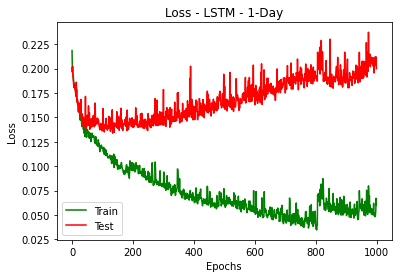

In [81]:
plt.plot(history.epoch, history.history["loss"], 'g', label = "Train")
plt.plot(history.epoch, history.history['val_loss'], 'r', label = "Test")
plt.title('Loss - LSTM - 1-Day')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
# Training 

model_3_day.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model_3_day.fit(
    train_x_dim, train_y_3_day,
    validation_data = (test_x_dim,  test_y_3_day),
    batch_size = 50,
    epochs = 1000
)

Epoch 1/1000
173/173 [==============================] - 4s 17ms/step - loss: 0.4107 - sparse_categorical_accuracy: 0.8449 - val_loss: 0.4105 - val_sparse_categorical_accuracy: 0.8399
Epoch 2/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.3897 - sparse_categorical_accuracy: 0.8486 - val_loss: 0.4105 - val_sparse_categorical_accuracy: 0.8416
Epoch 3/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.3843 - sparse_categorical_accuracy: 0.8497 - val_loss: 0.4018 - val_sparse_categorical_accuracy: 0.8413
Epoch 4/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.3817 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.3963 - val_sparse_categorical_accuracy: 0.8416
Epoch 5/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.3708 - sparse_categorical_accuracy: 0.8496 - val_loss: 0.3946 - val_sparse_categorical_accuracy: 0.8420
Epoch 6/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.3682 -

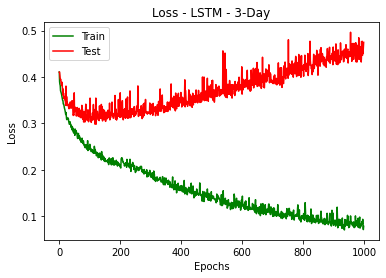

In [83]:
plt.plot(history.epoch, history.history["loss"], 'g', label = "Train")
plt.plot(history.epoch, history.history['val_loss'], 'r', label = "Test")
plt.title('Loss - LSTM - 3-Day')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [84]:
# Training 

model_5_day.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model_5_day.fit(
    train_x_dim, train_y_5_day,
    validation_data = (test_x_dim,  test_y_5_day),
    batch_size = 50, 
    epochs = 1000
)

Epoch 1/1000
173/173 [==============================] - 4s 18ms/step - loss: 0.5175 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.5328 - val_sparse_categorical_accuracy: 0.7418
Epoch 2/1000
173/173 [==============================] - 3s 16ms/step - loss: 0.4982 - sparse_categorical_accuracy: 0.7636 - val_loss: 0.5076 - val_sparse_categorical_accuracy: 0.7591
Epoch 3/1000
173/173 [==============================] - 3s 16ms/step - loss: 0.4922 - sparse_categorical_accuracy: 0.7659 - val_loss: 0.5042 - val_sparse_categorical_accuracy: 0.7584
Epoch 4/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.4891 - sparse_categorical_accuracy: 0.7707 - val_loss: 0.4956 - val_sparse_categorical_accuracy: 0.7795
Epoch 5/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.4794 - sparse_categorical_accuracy: 0.7748 - val_loss: 0.4930 - val_sparse_categorical_accuracy: 0.7598
Epoch 6/1000
173/173 [==============================] - 3s 16ms/step - loss: 0.4785 -

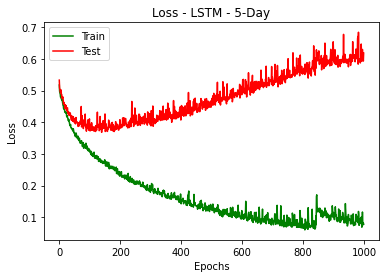

In [85]:
plt.plot(history.epoch, history.history["loss"], 'g', label = "Train")
plt.plot(history.epoch, history.history['val_loss'], 'r', label = "Test")
plt.title('Loss - LSTM - 5-Day')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Training 

model_7_day.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model_7_day.fit(
    train_x_dim, train_y_7_day,
    validation_data = (test_x_dim,  test_y_7_day),
    batch_size = 50,
    epochs = 1000
)

Epoch 1/1000
173/173 [==============================] - 4s 18ms/step - loss: 0.5894 - sparse_categorical_accuracy: 0.6824 - val_loss: 0.5756 - val_sparse_categorical_accuracy: 0.6966
Epoch 2/1000
173/173 [==============================] - 3s 16ms/step - loss: 0.5637 - sparse_categorical_accuracy: 0.7117 - val_loss: 0.5617 - val_sparse_categorical_accuracy: 0.7160
Epoch 3/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.5572 - sparse_categorical_accuracy: 0.7111 - val_loss: 0.5651 - val_sparse_categorical_accuracy: 0.6974
Epoch 4/1000
173/173 [==============================] - 3s 16ms/step - loss: 0.5497 - sparse_categorical_accuracy: 0.7239 - val_loss: 0.5529 - val_sparse_categorical_accuracy: 0.7270
Epoch 5/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.5439 - sparse_categorical_accuracy: 0.7236 - val_loss: 0.5548 - val_sparse_categorical_accuracy: 0.7164
Epoch 6/1000
173/173 [==============================] - 3s 15ms/step - loss: 0.5395 -

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'g', label = "Train")
plt.plot(history.epoch, history.history['val_loss'], 'r', label = "Test")
plt.title('Loss - LSTM - 7-Day')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluating

#Reshaping
#cv_x_dim = np.reshape(cv_x,(cv_x.shape[0],1, train_x.shape[1]))
#test_x_dim = np.reshape(test_x,(test_x.shape[0],1, test_x.shape[1]))

#Predicting 

train_pred_1_day_lstm = [np.argmax(i) for i in model_1_day.predict(train_x_dim)]
cv_pred_1_day_lstm = [np.argmax(i) for i in model_1_day.predict(cv_x_dim)]
test_pred_1_day_lstm = [np.argmax(i) for i in model_1_day.predict(test_x_dim)]

train_pred_3_day_lstm = [np.argmax(i) for i in model_3_day.predict(train_x_dim)]
cv_pred_3_day_lstm = [np.argmax(i) for i in model_3_day.predict(cv_x_dim)]
test_pred_3_day_lstm = [np.argmax(i) for i in model_3_day.predict(test_x_dim)]

train_pred_5_day_lstm = [np.argmax(i) for i in model_5_day.predict(train_x_dim)]
cv_pred_5_day_lstm = [np.argmax(i) for i in model_5_day.predict(cv_x_dim)]
test_pred_5_day_lstm = [np.argmax(i) for i in model_5_day.predict(test_x_dim)]


train_pred_7_day_lstm = [np.argmax(i) for i in model_7_day.predict(train_x_dim)]
cv_pred_7_day_lstm = [np.argmax(i) for i in model_7_day.predict(cv_x_dim)]
test_pred_7_day_lstm = [np.argmax(i) for i in model_7_day.predict(test_x_dim)]

In [ ]:
#pred 1 day

print("*********** SCORE for 1-DAY predict (Training Data) ***********")
print(classification_report(train_pred_1_day_lstm,train_y_1_day))


print()
print("*********** SCORE for 1-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_1_day_lstm,cv_y_1_day))

In [ ]:
#pred 3 day

print("*********** SCORE for 3-DAY predict (Training Data) ***********")
print(classification_report(train_pred_3_day_lstm,train_y_3_day))


print()
print("*********** SCORE for 3-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_3_day_lstm,cv_y_3_day))

In [ ]:
#pred 5 day

print("*********** SCORE for 5-DAY predict (Training Data)***********")
print(classification_report(train_pred_5_day_lstm,train_y_5_day))


print()
print("*********** SCORE for 5-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_5_day_lstm,cv_y_5_day))

In [ ]:
#pred 7 day

print("*********** SCORE for 7-DAY predict (Training Data)***********")
print(classification_report(train_pred_7_day_lstm,train_y_7_day))


print()
print("*********** SCORE for 7-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_7_day_lstm,cv_y_7_day))

In [ ]:
#Testing

print("*********** SCORE for 1-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_1_day_lstm,test_y_1_day))


print()
print("*********** SCORE for 3-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_3_day_lstm,test_y_3_day))

print()
print("*********** SCORE for 5-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_5_day_lstm,test_y_5_day))

print()
print("*********** SCORE for 7-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_7_day_lstm,test_y_7_day))

### Neural Network - Dense-1

In [ ]:
# Building the model

print(train_x.shape)

model_1_day_dense = Sequential(
    [                
        tf.keras.Input(shape=(389,)),
        layers.Dense(75, activation = 'sigmoid', name = 'layer1'),
        layers.Dense(25, activation = 'linear', name = 'layer2')

    ], name = "ModelDay1" 
)

print(model_1_day_dense.summary())

In [ ]:
# Building the model


model_3_day_dense = Sequential(
    [                
        tf.keras.Input(shape=(389,)),
        layers.Dense(75, activation = 'sigmoid', name = 'layer1'),
        layers.Dense(25, activation = 'linear', name = 'layer2')

    ], name = "ModelDay3" 
)

print(model_3_day_dense.summary())

In [ ]:
# Building the model

model_5_day_dense = Sequential(
    [                
        tf.keras.Input(shape=(389,)),  
        layers.Dense(75, activation = 'sigmoid', name = 'layer1'),
        layers.Dense(25, activation = 'linear', name = 'layer2')

    ], name = "ModelDay5" 
)

print(model_5_day_dense.summary())

In [ ]:
# Building the model

model_7_day_dense = Sequential(
    [                
        tf.keras.Input(shape=(389,)),  
        layers.Dense(75, activation = 'sigmoid', name = 'layer1'),
        layers.Dense(25, activation = 'linear', name = 'layer2')

    ], name = "ModelDay7" 
)

print(model_7_day_dense.summary())

In [ ]:
# Training 

model_1_day_dense.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model_1_day_dense.fit(
    train_x, train_y_1_day,
    validation_data = (test_x,  test_y_1_day),
    epochs=200
)

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'g', label = "Train")
plt.plot(history.epoch, history.history['val_loss'], 'r', label = "Test")
plt.title('Loss - Dense - 1-Day')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Training 

model_3_day_dense.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model_3_day_dense.fit(
    train_x, train_y_3_day,
    validation_data = (test_x,  test_y_3_day),
    epochs=200
)

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'g', label = "Train")
plt.plot(history.epoch, history.history['val_loss'], 'r', label = "Test")
plt.title('Loss - Dense - 3-Day')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Training 

model_5_day_dense.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model_5_day_dense.fit(
    train_x, train_y_5_day,
    validation_data = (test_x,  test_y_5_day),
    epochs=200
)

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'g', label = "Train")
plt.plot(history.epoch, history.history['val_loss'], 'r', label = "Test")
plt.title('Loss - Dense - 5-Day')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Training 

model_7_day_dense.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model_7_day_dense.fit(
    train_x, train_y_7_day,
    validation_data = (test_x,  test_y_7_day),
    epochs=200
)

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'g', label = "Train")
plt.plot(history.epoch, history.history['val_loss'], 'r', label = "Test")
plt.title('Loss - Dense - 7-Day')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluating

#Predicting 

train_pred_1_day_dense= [np.argmax(i) for i in model_1_day_dense.predict(train_x)]
cv_pred_1_day_dense = [np.argmax(i) for i in model_1_day_dense.predict(cv_x)]
test_pred_1_day_dense = [np.argmax(i) for i in model_1_day_dense.predict(test_x)]

train_pred_3_day_dense = [np.argmax(i) for i in model_3_day_dense.predict(train_x)]
cv_pred_3_day_dense = [np.argmax(i) for i in model_3_day_dense.predict(cv_x)]
test_pred_3_day_dense = [np.argmax(i) for i in model_3_day_dense.predict(test_x)]

train_pred_5_day_dense = [np.argmax(i) for i in model_5_day_dense.predict(train_x)]
cv_pred_5_day_dense = [np.argmax(i) for i in model_5_day_dense.predict(cv_x)]
test_pred_5_day_dense = [np.argmax(i) for i in model_5_day_dense.predict(test_x)]

train_pred_7_day_dense = [np.argmax(i) for i in model_7_day_dense.predict(train_x)]
cv_pred_7_day_dense = [np.argmax(i) for i in model_7_day_dense.predict(cv_x)]
test_pred_7_day_dense = [np.argmax(i) for i in model_7_day_dense.predict(test_x)]

In [ ]:
#pred 1 day

print("*********** SCORE for 1-DAY predict (Training Data) ***********")
print(classification_report(train_pred_1_day_dense,train_y_1_day))


print()
print("*********** SCORE for 1-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_1_day_dense,cv_y_1_day))

In [ ]:
#pred 3 day

print("*********** SCORE for 3-DAY predict (Training Data) ***********")
print(classification_report(train_pred_3_day_dense,train_y_3_day))


print()
print("*********** SCORE for 3-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_3_day_dense,cv_y_3_day))

In [ ]:
#pred 5 day

print("*********** SCORE for 5-DAY predict (Training Data) ***********")
print(classification_report(train_pred_5_day_dense,train_y_5_day))

print()
print("*********** SCORE for 5-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_5_day_dense,cv_y_5_day))

In [ ]:
#pred 7 day

print("*********** SCORE for 7-DAY predict (Training Data) ***********")
print(classification_report(train_pred_7_day_dense,train_y_7_day))

print()
print("*********** SCORE for 7-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_7_day_dense,cv_y_7_day))

In [ ]:
#Testing

print()
print("*********** SCORE for 1-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_1_day_dense,test_y_1_day))

print()
print("*********** SCORE for 3-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_3_day_dense,test_y_3_day))

print()
print("*********** SCORE for 5-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_5_day_dense,test_y_5_day))

print()
print("*********** SCORE for 7-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_7_day_dense,test_y_7_day))

### Neural network Dense-2

In [ ]:
# Building the model

print(train_x.shape)

model_1_day_dense = Sequential(
    [                
        tf.keras.Input(shape=(389,)),
        layers.Dense(100, activation = 'sigmoid', name = 'layer1'),
        layers.Dense(25, activation = 'sigmoid', name = 'layer2'),
        layers.Dense(2, activation = 'linear', name = 'layer3')

    ], name = "ModelDay1" 
)

print(model_1_day_dense.summary())

In [ ]:
# Building the model

model_3_day_dense = Sequential(
    [                
        tf.keras.Input(shape=(389,)),  
        layers.Dense(100, activation = 'sigmoid', name = 'layer1'),
        layers.Dense(25, activation = 'sigmoid', name = 'layer2'),
        layers.Dense(2, activation = 'linear', name = 'layer3')

    ], name = "ModelDay3" 
)

print(model_3_day_dense.summary())

In [ ]:
# Building the model

model_5_day_dense = Sequential(
    [                
        tf.keras.Input(shape=(389,)),  
        layers.Dense(100, activation = 'sigmoid', name = 'layer1'),
        layers.Dense(25, activation = 'sigmoid', name = 'layer2'),
        layers.Dense(2, activation = 'linear', name = 'layer3')

    ], name = "ModelDay5" 
)

print(model_5_day_dense.summary())

In [ ]:
# Building the model

model_7_day_dense = Sequential(
    [                
        tf.keras.Input(shape=(389,)),  
        layers.Dense(100, activation = 'sigmoid', name = 'layer1'),
        layers.Dense(25, activation = 'sigmoid', name = 'layer2'),
        layers.Dense(2, activation = 'linear', name = 'layer3')

    ], name = "ModelDay7" 
)

print(model_7_day_dense.summary())

In [ ]:
# Training 

model_1_day_dense.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model_1_day_dense.fit(
    train_x, train_y_1_day,
    validation_data = (test_x,  test_y_1_day),
    epochs=200
)

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'g', label = "Train")
plt.plot(history.epoch, history.history['val_loss'], 'r', label = "Test")
plt.title('Loss - Dense-2 - 1-Day')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Training 

model_3_day_dense.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model_3_day_dense.fit(
    train_x, train_y_3_day,
    validation_data = (test_x,  test_y_3_day),
    epochs=200
)

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'g', label = "Train")
plt.plot(history.epoch, history.history['val_loss'], 'r', label = "Test")
plt.title('Loss - Dense-2 - 3-Day')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Training 

model_5_day_dense.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model_5_day_dense.fit(
    train_x, train_y_5_day,
    validation_data = (test_x,  test_y_5_day),
    epochs=200
)

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'g', label = "Train")
plt.plot(history.epoch, history.history['val_loss'], 'r', label = "Test")
plt.title('Loss - Dense-2 - 5-Day')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Training 

model_7_day_dense.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model_7_day_dense.fit(
    train_x, train_y_7_day,
    validation_data = (test_x,  test_y_7_day),
    epochs=200
)

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'g', label = "Train")
plt.plot(history.epoch, history.history['val_loss'], 'r', label = "Test")
plt.title('Loss - Dense-2 - 7-Day')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluating

#Predicting 

train_pred_1_day_dense= [np.argmax(i) for i in model_1_day_dense.predict(train_x)]
cv_pred_1_day_dense = [np.argmax(i) for i in model_1_day_dense.predict(cv_x)]
test_pred_1_day_dense = [np.argmax(i) for i in model_1_day_dense.predict(test_x)]

train_pred_3_day_dense = [np.argmax(i) for i in model_3_day_dense.predict(train_x)]
cv_pred_3_day_dense = [np.argmax(i) for i in model_3_day_dense.predict(cv_x)]
test_pred_3_day_dense = [np.argmax(i) for i in model_3_day_dense.predict(test_x)]

train_pred_5_day_dense = [np.argmax(i) for i in model_5_day_dense.predict(train_x)]
cv_pred_5_day_dense = [np.argmax(i) for i in model_5_day_dense.predict(cv_x)]
test_pred_5_day_dense = [np.argmax(i) for i in model_5_day_dense.predict(test_x)]

train_pred_7_day_dense = [np.argmax(i) for i in model_7_day_dense.predict(train_x)]
cv_pred_7_day_dense = [np.argmax(i) for i in model_7_day_dense.predict(cv_x)]
test_pred_7_day_dense = [np.argmax(i) for i in model_7_day_dense.predict(test_x)]

In [ ]:
#pred 1 day

print("*********** SCORE for 1-DAY predict (Training Data) ***********")
print(classification_report(train_pred_1_day_dense,train_y_1_day))


print()
print("*********** SCORE for 1-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_1_day_dense,cv_y_1_day))

In [ ]:
#pred 3 day

print("*********** SCORE for 3-DAY predict (Training Data) ***********")
print(classification_report(train_pred_3_day_dense,train_y_3_day))


print()
print("*********** SCORE for 1-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_3_day_dense,cv_y_3_day))

In [ ]:
#pred 5 day

print("*********** SCORE for 5-DAY predict (Training Data) ***********")
print(classification_report(train_pred_5_day_dense,train_y_5_day))

print()
print("*********** SCORE for 5-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_5_day_dense,cv_y_5_day))

In [ ]:
#pred 7 day

print("*********** SCORE for 7-DAY predict (Training Data) ***********")
print(classification_report(train_pred_7_day_dense,train_y_7_day))

print()
print("*********** SCORE for 7-DAY predict (CV Data) ***********")
print(classification_report(cv_pred_7_day_dense,cv_y_7_day))

In [ ]:
#Testing

print("*********** SCORE for 1-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_1_day_dense,test_y_1_day))

print()
print("*********** SCORE for 3-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_3_day_dense,test_y_3_day))

print()
print("*********** SCORE for 5-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_5_day_dense,test_y_5_day))

print()
print("*********** SCORE for 7-DAY predict (Testing Data) ***********")
print(classification_report(test_pred_7_day_dense,test_y_7_day))